In [2]:
############################################################################################
# Program for the verification of AR-CHaMo-EPS forecasts
# (c) 2024-2025 ESSL Science & Training
# Programmer: Pieter Groenemeijer
############################################################################################

import eccodes as ec
import numpy as np
import numpy.ma as ma
from global_land_mask import globe
import testbedutils as tu
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
import xarray
import os
import concurrent.futures
import glob
import sys
import numexpr as ne
from numba import njit


%matplotlib inline
plt.rcParams["figure.facecolor"] = "w"

# Notes:
# cp V_2024060306_90_3_fcst.npy V_2024060318_90_3_fcst.npy
# cp V_2024050600_72_3_fcst.npy V_2024050603_75_3_fcst.npy
# cp V_2024060809_105_3_fcst.npy V_2024060812_108_3_fcst.npy

# Constants
ni, nj = 1800, 901
nm = 51 # Number of members
max_dist = 40 #km
hazardtype_long = {'LIGHTNING': 'prob_lightning',\
                   'HAIL'     : 'prob_hail_ge2cm',\
                   'SIGHAIL'  : 'prob_hail_ge5cm', } 
forecastbasedir = '/home/testbed/data/models/archamo-eps' 
eswdbasedir     = '/home/testbed/wx/obs/eswd'
verif_path      = '/home/testbed/data/models/archamo-eps/verif'
lats, lons      = [], []

hazardtype = "HAIL"

def GetLatsLons(grib_message_id):
    
    #This function extracts and returns the latitude and longitude grid of a GRIB message
    
    firstlat     = ec.codes_get(grib_message_id, 'latitudeOfFirstGridPointInDegrees')
    firstlon     = ec.codes_get(grib_message_id, 'longitudeOfFirstGridPointInDegrees')
    steplat      = ec.codes_get(grib_message_id, 'jDirectionIncrementInDegrees')
    steplon      = ec.codes_get(grib_message_id, 'iDirectionIncrementInDegrees')
    latdirection = ec.codes_get(grib_message_id, 'jScansPositively')

    if latdirection == 0:
        steplat = -steplat

    lastlon = firstlon + ni * steplon

    lats = np.arange(firstlat, firstlat + nj * steplat, steplat)[0:nj]
    lons = np.arange(firstlon, firstlon + ni * steplon, steplon)[0:ni]
    
    lons[lons>=180] = lons[lons>=180] - 360
    
    return lats, lons


def ConstrainForecastToDomain(my_forecast, lats, lons, domain_given):

    # Cuts out a subsection of the grib message and flips the latitude
    
    if lats[-1] < lats[0]:
#        tu.Timestamp('Flipping latitude axis')
        lats = lats[::-1]
        my_forecast = my_forecast[::-1,:,:]
    
    domains = tu.ReadDomains(domain_given, 'ecmwf')
    lonmin, lonmax, latmin, latmax = domains[0]['lonmin'], domains[0]['lonmax'], domains[0]['latmin'], domains[0]['latmax']

    if lons[0] > lonmin:
#        tu.Timestamp('Rolling data to -180 to 180 longitude')
        mid_idx = int(len(lons)/2)
        lons = np.roll(lons, mid_idx)
        my_forecast = np.roll(my_forecast, mid_idx, axis=1)

    index_of_lonmin = np.argmax(lons >= lonmin)
    index_of_lonmax = np.argmax(lons >= lonmax)
    index_of_latmin = np.argmax(lats >= latmin)
    index_of_latmax = np.argmax(lats >= latmax)
   
    my_forecast = my_forecast[index_of_latmin:index_of_latmax, index_of_lonmin:index_of_lonmax, :]
    lats = lats[index_of_latmin:index_of_latmax]
    lons = lons[index_of_lonmin:index_of_lonmax]
    
    return my_forecast, lats, lons



def ReadForecast(hazardtype, initdtg, forecasthour, domain, filter_land=True, max_members=51):

    # This function reads and returns the data of a set of grib messages (the ensemble members)
    # and their geographical coordinates. It assumes all members have the same grid.
    # It also "temporally upscales" the forecasts from hourly to 3-hourly by inflating the probabilities
    
    global forecastbasedir
    my_forecast = np.empty([nj, ni, nm], dtype=np.float32)
    
    forecast_filename = forecastbasedir + '/' + str(initdtg) + '/' + hazardtype + '_' + str(initdtg) + '_' + str(forecasthour) + '.grib'
    grib_filehandle = open(forecast_filename, 'rb')
    
    i = 0
#    tu.Timestamp('Reading in up to ' + str(max_members) + ' members from run ' + str(initdtg) + ' at +' + str(forecasthour) + ' hours')
    
    while i < max_members:
        grib_message_id = ec.codes_grib_new_from_file(grib_filehandle)
        
        if grib_message_id == None: # last message in grib file
            break

        if i == 0: # Get latitudes and longitudes. Assume this is the same for all ensemble members 
            lats, lons = GetLatsLons(grib_message_id)
            
        my_forecast[:,:,i] = ec.codes_get_values(grib_message_id).reshape(nj, ni)
            
        i = i + 1
        ec.codes_release(grib_message_id)

    my_forecast, lats, lons = ConstrainForecastToDomain(my_forecast, lats, lons, domain)

#    tu.Timestamp('Scaling forecasts to 3 hour criterion...')
    my_forecast = 1 - (1 - my_forecast) ** 3
    
#    tu.Timestamp('Scaling forecasts to 40 km radius criterion...')
    my_forecast = 1 - (1 - my_forecast) ** 9.2
    
#    tu.Timestamp('Averaging members...')
    my_forecast = np.mean(my_forecast, axis = 2)

    lons2d, lats2d = np.meshgrid(lons, lats)
    
    if filter_land:
#        tu.Timestamp('Masking seas...')
        land_mask = globe.is_land(lats2d,lons2d)
        my_forecast[~land_mask] = np.NaN
    
    return my_forecast, lats, lons



def AddHours(dtg, hours):
    
    # This simple routine adds a number of hours to a certain date-time-group string
    
    init_time   = datetime.datetime.strptime(dtg, "%Y%m%d%H")
    valid_time  = init_time + datetime.timedelta(hours=hours)
        
    return valid_time.strftime('%Y%m%d%H')



#def DistanceQuicker(lons, lats, ref_lon, ref_lat):
#    
#    #  This function returns the distance of a (lat lon grid point) to a reference grid
#    
#    earth_radius = 6378
#    max_dist_deg = 5 # degrees
#    
#    my_dist = np.ones(lons.shape) * np.inf
#
#    print(lons.shape, lons, ref_lon, ref_lon - max_dist_deg)
#    
#    minlonindex = np.argmax(lons[lons >  ref_lon - max_dist_deg])
#    maxlonindex = np.argmax(lons[lons >= ref_lon + max_dist_deg])
#    minlatindex = np.argmax(lats[lats >  ref_lat - max_dist_deg])
#    maxlatindex = np.argmax(lats[lats >= ref_lat + max_dist_deg])
#   
#    print(minlonindex, maxlonindex, minlatindex, maxlatindex)
#                                 
#    lat_dif = np.radians(my_lons[minlonindex:maxlonindex, minlatindex:maxlatindex] - ref_lat)
#    lon_dif = np.radians(my_lats[minlonindex:maxlonindex, minlatindex:maxlatindex] - ref_lon)
#    
#    sin_d_lat = np.sin(lat_dif / 2.)
#    sin_d_lon = np.sin(lon_dif / 2.)
#
#    step_1 = (sin_d_lat ** 2) + (sin_d_lon ** 2) * np.cos(np.radians(lats)) * np.cos(np.radians(ref_lat)) 
#    my_dist[minlonindex:maxlonindex, minlatindex:maxlatindex] = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1)) * earth_radius
#                                 
#    
#    return dist


def Distance(lons, lats, ref_lon, ref_lat):
    
    #  This function returns the distance of a (lat lon grid point) to a reference grid
    
    earth_radius = 6378
    
    lat_dif = np.radians(lats - ref_lat)
    lon_dif = np.radians(lons - ref_lon)

#    print('lat_dif.shape', lat_dif.shape)
#    print('lat_dif.shape', ref_lon.shape)
#    print('lat_dif.shape', lons.shape)
    
    sin_d_lat = np.sin(lat_dif / 2.)
    sin_d_lon = np.sin(lon_dif / 2.)

    #step_1 = (sin_d_lat ** 2) + (sin_d_lon ** 2) * np.cos(np.radians(lats)) * np.cos(np.radians(ref_lat)) 
    #step_2 = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))
    
    lats_rad = np.radians(lats)
    ref_lat_rad = np.radians(ref_lat)
    
    step_1 = ne.evaluate("(sin_d_lat ** 2) + (sin_d_lon ** 2) * cos(lats_rad) * cos(ref_lat_rad)") 
    dist = ne.evaluate("2 * arctan2(sqrt(step_1), sqrt(1-step_1)) * earth_radius") 

#    dist = step_2 * earth_radius
#    print('dist.shape', dist.shape)
    
    return dist



def Distances(lons, lats, ref_lons, ref_lats):
    
    #  This function returns the distance of a (lat lon grid point) to a reference grid
    
    earth_radius = 6378

    ref_lons = np.array(ref_lons, dtype=np.float64)
    ref_lats = np.array(ref_lats, dtype=np.float64)
    
    lat_difs = np.radians(lats[:, None] - ref_lats[None, :])
    lon_difs = np.radians(lons[:, None] - ref_lons[None, :])

    print('lat_difs.shape', lat_difs.shape)
#    print('lat_dif.shape', ref_lon.shape)
#    print('lat_dif.shape', lons.shape)
    
    sin_d_lats = np.sin(lat_difs / 2.)
    sin_d_lons = np.sin(lon_difs / 2.)

    #step_1 = (sin_d_lat ** 2) + (sin_d_lon ** 2) * np.cos(np.radians(lats)) * np.cos(np.radians(ref_lat)) 
    #step_2 = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))
    
    lats_rad = np.radians(lats[:, None] )
    ref_lat_rad = np.radians(ref_lats[None, :])
    
    step_1 = ne.evaluate("(sin_d_lats ** 2) + (sin_d_lons ** 2) * cos(lats_rad) * cos(ref_lat_rad)") 
    dist   = ne.evaluate("2 * arctan2(sqrt(step_1), sqrt(1-step_1)) * earth_radius") 

#    dist = step_2 * earth_radius
#    print('dist.shape', dist.shape)
    
    return dist


def Distances2D(lons2d, lats2d, ref_lons, ref_lats, lon_window, lat_window):
    
    earth_radius = 6378

    ref_lons = np.array(ref_lons, dtype=np.float64)
    ref_lats = np.array(ref_lats, dtype=np.float64)
            
    dist = np.ones((ref_lons.shape[0], lons2d.shape[0], lons2d.shape[1])) * np.nan

#    print('lons2d.shape', lons2d.shape)    
#    print('lons2d[0, :]', lons2d[0, :])
#    print('ref_lons', ref_lons)
#    print('lats2d[0, :]', lats2d[:, 0])
#    print('ref_lats', ref_lats)
   
    lonindex = np.argmax(lons2d[0, :] >  ref_lons[:, None, None], axis=2)[:, 0]
    minlonindex = np.maximum(lonindex - lon_window, 0)
    maxlonindex = np.minimum(lonindex + lon_window, lons2d.shape[1])
    minlonindex[maxlonindex == lons2d.shape[1]] = lons2d.shape[1] - lon_window * 2
    maxlonindex[minlonindex == 0] = lon_window * 2
    
    latindex = np.argmax(lats2d[:, 0] >  ref_lats[:, None, None], axis=2)[:, 0]
    minlatindex = np.maximum(latindex - lat_window, 0)
    maxlatindex = np.minimum(latindex + lat_window, lons2d.shape[0])
    minlatindex[maxlatindex == lons2d.shape[0]] = lons2d.shape[0] - lat_window * 2
    maxlatindex[minlatindex == 0] = lat_window * 2
    
#    print('minlonindex.shape', minlonindex.shape)
#    print('minlonindex, maxlonindex, minlatindex, maxlatindex', minlonindex, maxlonindex, minlatindex, maxlatindex)
#    print('maxlatindex[0] - minlatindex[0], maxlonindex[0] - minlonindex[0]', maxlatindex[0] - minlatindex[0], maxlonindex[0] - minlonindex[0])
    
    my_lats2d = np.ones((ref_lons.shape[0], maxlatindex[0] - minlatindex[0], maxlonindex[0] - minlonindex[0])) * np.inf
    my_lons2d = np.ones((ref_lons.shape[0], maxlatindex[0] - minlatindex[0], maxlonindex[0] - minlonindex[0])) * np.inf
    
    @njit
    def MyFunction(ref_lons, my_lats2d, my_lons2d, lats2d, lons2d, minlatindex, maxlatindex, minlonindex, maxlonindex):
        for i in range(0, ref_lons.shape[0]):
            my_lats2d[i, :, :] = lats2d[minlatindex[i]: maxlatindex[i], minlonindex[i]: maxlonindex[i]]
            my_lons2d[i, :, :] = lons2d[minlatindex[i]: maxlatindex[i], minlonindex[i]: maxlonindex[i]]
        return my_lats2d, my_lons2d

    my_lats2d, my_lons2d = MyFunction(ref_lons, my_lats2d, my_lons2d, lats2d, lons2d, minlatindex, maxlatindex, minlonindex, maxlonindex)
    
#    print('my_lats2d.shape', my_lats2d.shape)
#    
#    lat_dif = np.radians(my_lons[minlonindex:maxlonindex, minlatindex:maxlatindex] - ref_lat)
#    lon_dif = np.radians(my_lats[minlonindex:maxlonindex, minlatindex:maxlatindex] - ref_lon)
    
    earth_radius = 6378
        
    lat_difs = np.radians(my_lats2d - ref_lats[:, None, None])
    lon_difs = np.radians(my_lons2d - ref_lons[:, None, None])

    #print('lat_difs.shape', lat_difs.shape)
#    print('lat_dif.shape', ref_lon.shape)
#    print('lat_dif.shape', lons.shape)
    
    sin_d_lats = np.sin(lat_difs / 2.)
    sin_d_lons = np.sin(lon_difs / 2.)

    #step_1 = (sin_d_lat ** 2) + (sin_d_lon ** 2) * np.cos(np.radians(lats)) * np.cos(np.radians(ref_lat)) 
    #step_2 = 2 * np.arctan2(np.sqrt(step_1), np.sqrt(1-step_1))
    
    lats2d_rad = np.radians(my_lats2d)
    ref_lat_rad = np.radians(ref_lats[:, None, None])

#    print('sin_d_lats.shape',  sin_d_lats.shape)
#    print('sin_d_lons.shape',  sin_d_lons.shape)
#    print('lats2d_rad.shape',  lats2d_rad.shape)
#    print('ref_lat_rad.shape', ref_lat_rad.shape)
    
    step_1  = ne.evaluate("(sin_d_lats ** 2) + (sin_d_lons ** 2) * cos(lats2d_rad) * cos(ref_lat_rad)") 
    my_dist = ne.evaluate("2 * arctan2(sqrt(step_1), sqrt(1-step_1)) * earth_radius") 

    @njit
    def MyFunction2(ref_lons, dist, my_dist, minlatindex, maxlatindex, minlonindex, maxlonindex):
        for i in range(0, ref_lons.shape[0]):
            dist[i, minlatindex[i]: maxlatindex[i], minlonindex[i]: maxlonindex[i]] = my_dist[i]
        return dist
    
    dist = MyFunction2(ref_lons, dist, my_dist, minlatindex, maxlatindex, minlonindex, maxlonindex)
    
#ValueError: operands could not be broadcast together with shapes (2081,14,20) (2081,) (2081,14,20) (2081,14,20) 
    
#    dist = step_2 * earth_radius
#    print('dist.shape', dist.shape)
    
    return dist



def ReadObservations(hazardtype, dtg, lats, lons, period_in_hours, max_dist, filter_land=True):

    # This function reads severe weather observations and provides a grid of values indicating
    # if an observation is present within a certain radius of max_dist from that point
    # 1 = yes, there was an observation within max_dist, 0 = no, no observation within max_dist
    
    global eswdbasedir

    lons2d, lats2d = np.meshgrid(lons, lats)
    
    maxdtg = AddHours(dtg, period_in_hours)
    
    my_observations = np.full((len(lats), len(lons)), 0.0)
   
    with open(eswdbasedir + '/' + dtg[0:8] + '.dat') as fh:
        for line in fh:
            
            my_time, my_lat, my_lon, my_hazard = line.split()[0:4]
            my_dtg = dtg[0:8] + my_time
            if my_hazard == hazardtype:
                if my_dtg >= dtg and my_dtg < maxdtg:
                    #print(my_hazard, my_dtg, my_lat, my_lon)
                    dist = Distance(lons2d, lats2d, float(my_lon), float(my_lat)) #distance matrix
                    #print('dist.shape', dist.shape)
                   
                    my_observations[dist < max_dist] = 1.0
                    
    if filter_land:
        tu.Timestamp('Masking seas...')
        land_mask = globe.is_land(lats2d,lons2d)
        my_observations[~land_mask] = np.NaN
        
    return my_observations


def WriteObservations(observations, dtg, domain, period_in_hours, hazard):

    # This function writes gridded observations to disk
    
    directory = verif_path + '/' + domain + '/' + hazard
    filename = directory + '/' + str(dtg) + '_' + str(period_in_hours) + '_obs.npy'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    np.save(filename, observations)
    tu.Timestamp('Saved obs to: ' + filename)
    

def WriteForecasts(observations, dtg, forecasthour, domain, period_in_hours, hazard):

    # This function writes gridded forecasts to disk
    
    directory = verif_path + '/' + domain + '/' + hazard
    filename = directory + '/V_' + str(dtg) + '_' + str(forecasthour) + '_' + str(period_in_hours) + '_fcst.npy'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    np.save(filename, observations)
    tu.Timestamp('Saved: ' + filename)
    sys.stdout.flush()
    
    
def ReadAndWriteForecast(hazardtype, initdtg, forecasthour, domain, period_in_hours):

    # This function calls both the read and the write functions for the forecasts.
    # It is defined separately, so both reading and writing can easily be called 
    # as a single job in a thread pool

#    print("Pre-processing forecast of", initdtg, "valid at +", forecasthour, "h", flush=True)
#    sys.stdout.flush()
    
    forecast, lats, lons = ReadForecast (hazardtype_long[hazardtype], initdtg, forecasthour, domain, filter_land=True)
    dtg = AddHours(str(initdtg), forecasthour)
    WriteForecasts(forecast, dtg, forecasthour, domain, period_in_hours, hazardtype)
#    print("Pre-processed forecast of", initdtg, "valid at +", forecasthour, "h", flush=True)
#    sys.stdout.flush()
    
    return


def ReadAndWriteObservations(hazardtype, dtg, lats, lons, domain, period_in_hours, max_dist):

    # This function calls both the read and the write function for the observations.
    # It is defined separately, so both reading and writing can easily be called 
    # as a single job in a thread pool
    
    observations = ReadObservations(hazardtype, dtg, lats, lons, period_in_hours, max_dist, filter_land=True)
    WriteObservations(observations, dtg, domain, period_in_hours, hazardtype)

    return 



def PreProcessObs(hazardtypes, initdtg, lastdtg, domain, period_in_hours):

    # Loop over all observations: read them, process them and write them to files
    
    global lats, lons
    
    pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
    dtg = initdtg

    # read one forecast to get grid coordinates (assumed to be identical for all forecasts)
    forecast, lats, lons = ReadForecast (hazardtype_long[hazardtypes[0]], initdtg, 0, domain, filter_land=True, max_members=1)

    futures = []
    
    for hazardtype in hazardtypes:
        print('Hazard type:', hazardtype)
       
        while int(dtg) <= int(lastdtg):

            #futures.append(pool.submit(ReadAndWriteObservations, hazardtype, dtg, lats, lons, domain, period_in_hours, max_dist))
            ReadAndWriteObservations(hazardtype, dtg, lats, lons, domain, period_in_hours, max_dist)
            dtg = AddHours(str(dtg), period_in_hours)
        
    return


            
def PreProcessForecasts(forecasthour_start, forecasthour_end, period_in_hours, firstinit, lastinit, initstep, hazardtype):

    # Loop over all forecasts: read them, process them and write them to files
    
#    print("Starting Pre-Processing from", forecasthour_start, "to", forecasthour_end, "with step", period_in_hours)
    
    pool = concurrent.futures.ProcessPoolExecutor(max_workers=16) # run processes in parallel
    step = 12 # step of initialization times
    forecasthour = forecasthour_start
    initdtg = str(firstinit)

    #forecast, lats, lons = ReadForecast (hazardtype_long[hazardtypes[0]], firstinitdtg, forecasthour, domain, filter_land=True, max_members=1)

    futures = []
    
    while int(initdtg) <= lastinit:
        forecasthour = forecasthour_start
        
        while forecasthour <= forecasthour_end: #int(initdtg) <= int(lastdtg):

            print(initdtg, forecasthour)
#            #sys.stdout.flush()
            
            futures.append(pool.submit(ReadAndWriteForecast, hazardtype, initdtg, forecasthour, domain, period_in_hours))
#            #ReadAndWriteForecast(hazardtype, initdtg, forecasthour, domain, period_in_hours)
            forecasthour = forecasthour + period_in_hours
        
        initdtg = AddHours(str(initdtg), initstep)
        
        
            
def Upscaled(probdata, hours):
    
    # Temporally upscale forecast probabilities (naively assuming independence)
    
    my_data = 1 - (1 - probdata)**hours
    
    return my_data


    
def CombineProbs(list_of_probabilities):
    
    # Combine multiple  probabilities, naively assuming independence

    factor = 1
    
    for my_prob in list_of_probabilities:
        factor = factor * (1 - my_prob)
    
    my_data = 1 - factor
    
    print(my_data.shape)
    return my_data



No tempdir indicated, assuming /tmp should be used.


In [3]:
def PreProcessLightningObs(initdtg, lastdtg, domain, period_in_hours):

    # Loop over all observations: read them, process them and write them to files

    lightning_data_path = "/mnt/essl_nas05/climate/LIGHTNING/GLOBAL/LEELA"
    filter_land = True
    
    global lats, lons

    pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
    dtg = initdtg

    # read one forecast to get grid coordinates (assumed to be identical for all forecasts)
    forecast, lats, lons = ReadForecast (hazardtype_long[hazardtypes[0]], initdtg, 0, domain, filter_land=True, max_members=1)
    
    latmin = np.min(lats)
    latmax = np.max(lats)
    lonmin = np.min(lons)
    lonmax = np.max(lons)
    lons2d, lats2d = np.meshgrid(lons, lats)
    print('lons2d.shape', lats2d.shape)
    
    futures = []
   
    while int(dtg) <= int(lastdtg):
        
        maxdtg = AddHours(dtg, period_in_hours)
        my_observations = np.full((len(lats) * len(lons)), 0.0)

        flash_lons = []
        flash_lats = []
        
        print(lightning_data_path + '/LEELA_ESSL_' + dtg[0:8] + '.csv')

        lightningfilename = lightning_data_path + '/LEELA_ESSL_' + dtg[0:8] + '.csv'
        with open(lightningfilename, "r") as f:

            for line in f:
                if line[0] == '#':
                    continue

                l_yyyy, l_month, l_day, l_hour, l_minute, l_sec, l_lat, l_lon = line.split(',')[0:8]
                l_dtg = str(int(l_yyyy)) + '{:0>2}'.format(int(l_month)) +\
                            '{:0>2}'.format(int(l_day)) + '{:0>2}'.format(int(l_hour))

                if int(l_dtg) >= int(dtg) and int(l_dtg) < int(maxdtg):
                    if (float(l_lon) > lonmin) and (float(l_lon) < lonmax) and (float(l_lat) > latmin) and (float(l_lat) < latmax):
                        flash_lons.append(l_lon)
                        flash_lats.append(l_lat)
                        
        print(len(flash_lons))

        dist = Distances2D(lons2d, lats2d, flash_lons, flash_lats, 5, 4) #distance matrix
        close_points = dist < max_dist
        print(close_points.shape, my_observations.shape)
        
        my_observations[np.sum(close_points, axis=1)] = 1.0                
        my_observations = my_observations.flatten()

        if filter_land:
            tu.Timestamp('Masking seas...')
            land_mask = globe.is_land(lats2d.flatten(), lons2d.flatten())
            my_observations[~land_mask] = np.NaN
            
        directory = verif_path + '/' + domain + '/LIGHTNING'
        filename = directory + '/' + str(dtg) + '_' + str(period_in_hours) + '_obs.npy'

        if not os.path.exists(directory):
            os.makedirs(directory)

        np.save(filename, my_observations)
        tu.Timestamp('Saved obs to: ' + filename)

        dtg = AddHours(str(dtg), period_in_hours)
        
    return


In [259]:
def PreProcessLightningObsOld(initdtg, lastdtg, domain, period_in_hours):

    # Loop over all observations: read them, process them and write them to files

    lightning_data_path = "/mnt/essl_nas05/climate/LIGHTNING/GLOBAL/LEELA"
    filter_land = True
    
    global lats, lons
    lons2d, lats2d = np.meshgrid(lons, lats)
    print('lons2d.shape', lats2d.shape)
    
    pool = concurrent.futures.ProcessPoolExecutor(max_workers=2)
    dtg = initdtg

    # read one forecast to get grid coordinates (assumed to be identical for all forecasts)
    forecast, lats, lons = ReadForecast (hazardtype_long[hazardtypes[0]], initdtg, 0, domain, filter_land=True, max_members=1)
    
    latmin = np.min(lats)
    latmax = np.max(lats)
    lonmin = np.min(lons)
    lonmax = np.max(lons)
    
    futures = []
   
    while int(dtg) <= int(lastdtg):
        
        maxdtg = AddHours(dtg, period_in_hours)
        my_observations = np.full((len(lats) * len(lons)), 0.0)

        flash_lons = []
        flash_lats = []
        
        print(lightning_data_path + '/LEELA_ESSL_' + dtg[0:8] + '.csv')

        lightningfilename = lightning_data_path + '/LEELA_ESSL_' + dtg[0:8] + '.csv'
        with open(lightningfilename, "r") as f:

            for line in f:
                if line[0] == '#':
                    continue

                l_yyyy, l_month, l_day, l_hour, l_minute, l_sec, l_lat, l_lon = line.split(',')[0:8]
                l_dtg = str(int(l_yyyy)) + '{:0>2}'.format(int(l_month)) +\
                            '{:0>2}'.format(int(l_day)) + '{:0>2}'.format(int(l_hour))

                if int(l_dtg) >= int(dtg) and int(l_dtg) < int(maxdtg):
                    if (float(l_lon) > lonmin) and (float(l_lon) < lonmax) and (float(l_lat) > latmin) and (float(l_lat) < latmax):
                        flash_lons.append(l_lon)
                        flash_lats.append(l_lat)
                        
        print(len(flash_lons))

        dist = Distances(lons2d, lats2d, flash_lons, flash_lats) #distance matrix
        close_points = dist < max_dist
        print(close_points.shape, my_observations.shape)
        
        my_observations[np.sum(close_points, axis=1)] = 1.0                

        if filter_land:
            tu.Timestamp('Masking seas...')
            land_mask = globe.is_land(lats2d, lons2d)
            my_observations[~land_mask] = np.NaN    
   
        directory = verif_path + '/' + domain + '/LIGHTNING'
        filename = directory + '/' + str(dtg) + '_' + str(period_in_hours) + '_obs.npy'

        if not os.path.exists(directory):
            os.makedirs(directory)

        np.save(filename, my_observations)
        tu.Timestamp('Saved obs to: ' + filename)

        dtg = AddHours(str(dtg), period_in_hours)
        
    return


In [4]:
# PreProcessLightningObservations

preprocess_lightning_observations = False # Set to to True if this is needed

period_in_hours = 3
domain = 'EURO'
hazardtypes = ['HAIL', 'SIGHAIL']

firstinit = '2024050100'
lastinit  = '2024101500'
initstep  = 12

if preprocess_lightning_observations: # read them in, grid them, and save as npy array file

    PreProcessLightningObs(firstinit, lastinit, domain, period_in_hours)

In [5]:
# PreProcessObservations


preprocess_observations = False # Set to to True if this is needed

period_in_hours = 3
domain = 'EURO'
hazardtypes = ['HAIL', 'SIGHAIL']

firstinit = '2024050100'
lastinit  = '2024101500'
initstep  = 12

if preprocess_observations: # read them in, grid them, and save as npy array file

    PreProcessObs(hazardtypes, firstinit, lastinit, domain, period_in_hours)


In [6]:
# PreProcessForecasts
# This can easily take 45 minutes per month of forecasts

preprocess_forecasts = False

firstinitdtg = 2024050100 # date-time-group of first forecast to process: yyyymmmddhh
lastdtg      = 2024101500 # date-time-group of last forecast to process:  yyyymmmddhh

if preprocess_forecasts:
    
    PreProcessForecasts(  3, 144, 3, firstinitdtg, lastdtg, initstep, hazardtype) # Process forecasts for +3 until +144 h, with 3h steps
    PreProcessForecasts(144, 240, 6, firstinitdtg, lastdtg, initstep, hazardtype) # Process forecasts for +144 until 240 h with 6h steps



In [49]:
domain = 'EURO'
period_in_hours = 3

# Read Pre-processed Observation Files

filelist_obs = sorted(glob.glob(verif_path + '/' + domain + '/' + hazardtype + '/' + '*_' + str(period_in_hours) + '_obs.npy'))

my_obs_data_readin = np.load(filelist_obs[0])
ny, nx = my_obs_data_readin.shape

dates_obs = []

obs_data_readin = np.zeros([ny * nx, len(filelist_obs)])

print(obs_data_readin.shape)

for i, my_file in enumerate(filelist_obs):
    print(my_file[-28:], end = " ")
    obs_data_readin[:,i] = np.load(my_file).flatten()
    index = len(verif_path + '/' + domain + '/' + hazardtype + '/')
    dates_obs.append(my_file[index:index+10])            
    print(my_file[index:])

    

(68400, 1337)
RO/HAIL/2024050100_3_obs.npy 2024050100_3_obs.npy
RO/HAIL/2024050103_3_obs.npy 2024050103_3_obs.npy
RO/HAIL/2024050106_3_obs.npy 2024050106_3_obs.npy
RO/HAIL/2024050109_3_obs.npy 2024050109_3_obs.npy
RO/HAIL/2024050112_3_obs.npy 2024050112_3_obs.npy
RO/HAIL/2024050115_3_obs.npy 2024050115_3_obs.npy
RO/HAIL/2024050118_3_obs.npy 2024050118_3_obs.npy
RO/HAIL/2024050121_3_obs.npy 2024050121_3_obs.npy
RO/HAIL/2024050200_3_obs.npy 2024050200_3_obs.npy
RO/HAIL/2024050203_3_obs.npy 2024050203_3_obs.npy
RO/HAIL/2024050206_3_obs.npy 2024050206_3_obs.npy
RO/HAIL/2024050209_3_obs.npy 2024050209_3_obs.npy
RO/HAIL/2024050212_3_obs.npy 2024050212_3_obs.npy
RO/HAIL/2024050215_3_obs.npy 2024050215_3_obs.npy
RO/HAIL/2024050218_3_obs.npy 2024050218_3_obs.npy
RO/HAIL/2024050221_3_obs.npy 2024050221_3_obs.npy
RO/HAIL/2024050300_3_obs.npy 2024050300_3_obs.npy
RO/HAIL/2024050303_3_obs.npy 2024050303_3_obs.npy
RO/HAIL/2024050306_3_obs.npy 2024050306_3_obs.npy
RO/HAIL/2024050309_3_obs.npy 2024050

RO/HAIL/2024052315_3_obs.npy 2024052315_3_obs.npy
RO/HAIL/2024052318_3_obs.npy 2024052318_3_obs.npy
RO/HAIL/2024052321_3_obs.npy 2024052321_3_obs.npy
RO/HAIL/2024052400_3_obs.npy 2024052400_3_obs.npy
RO/HAIL/2024052403_3_obs.npy 2024052403_3_obs.npy
RO/HAIL/2024052406_3_obs.npy 2024052406_3_obs.npy
RO/HAIL/2024052409_3_obs.npy 2024052409_3_obs.npy
RO/HAIL/2024052412_3_obs.npy 2024052412_3_obs.npy
RO/HAIL/2024052415_3_obs.npy 2024052415_3_obs.npy
RO/HAIL/2024052418_3_obs.npy 2024052418_3_obs.npy
RO/HAIL/2024052421_3_obs.npy 2024052421_3_obs.npy
RO/HAIL/2024052500_3_obs.npy 2024052500_3_obs.npy
RO/HAIL/2024052503_3_obs.npy 2024052503_3_obs.npy
RO/HAIL/2024052506_3_obs.npy 2024052506_3_obs.npy
RO/HAIL/2024052509_3_obs.npy 2024052509_3_obs.npy
RO/HAIL/2024052512_3_obs.npy 2024052512_3_obs.npy
RO/HAIL/2024052515_3_obs.npy 2024052515_3_obs.npy
RO/HAIL/2024052518_3_obs.npy 2024052518_3_obs.npy
RO/HAIL/2024052521_3_obs.npy 2024052521_3_obs.npy
RO/HAIL/2024052600_3_obs.npy 2024052600_3_obs.npy


RO/HAIL/2024061715_3_obs.npy 2024061715_3_obs.npy
RO/HAIL/2024061718_3_obs.npy 2024061718_3_obs.npy
RO/HAIL/2024061721_3_obs.npy 2024061721_3_obs.npy
RO/HAIL/2024061800_3_obs.npy 2024061800_3_obs.npy
RO/HAIL/2024061803_3_obs.npy 2024061803_3_obs.npy
RO/HAIL/2024061806_3_obs.npy 2024061806_3_obs.npy
RO/HAIL/2024061809_3_obs.npy 2024061809_3_obs.npy
RO/HAIL/2024061812_3_obs.npy 2024061812_3_obs.npy
RO/HAIL/2024061815_3_obs.npy 2024061815_3_obs.npy
RO/HAIL/2024061818_3_obs.npy 2024061818_3_obs.npy
RO/HAIL/2024061821_3_obs.npy 2024061821_3_obs.npy
RO/HAIL/2024061900_3_obs.npy 2024061900_3_obs.npy
RO/HAIL/2024061903_3_obs.npy 2024061903_3_obs.npy
RO/HAIL/2024061906_3_obs.npy 2024061906_3_obs.npy
RO/HAIL/2024061909_3_obs.npy 2024061909_3_obs.npy
RO/HAIL/2024061912_3_obs.npy 2024061912_3_obs.npy
RO/HAIL/2024061915_3_obs.npy 2024061915_3_obs.npy
RO/HAIL/2024061918_3_obs.npy 2024061918_3_obs.npy
RO/HAIL/2024061921_3_obs.npy 2024061921_3_obs.npy
RO/HAIL/2024062000_3_obs.npy 2024062000_3_obs.npy


RO/HAIL/2024070921_3_obs.npy 2024070921_3_obs.npy
RO/HAIL/2024071000_3_obs.npy 2024071000_3_obs.npy
RO/HAIL/2024071003_3_obs.npy 2024071003_3_obs.npy
RO/HAIL/2024071006_3_obs.npy 2024071006_3_obs.npy
RO/HAIL/2024071009_3_obs.npy 2024071009_3_obs.npy
RO/HAIL/2024071012_3_obs.npy 2024071012_3_obs.npy
RO/HAIL/2024071015_3_obs.npy 2024071015_3_obs.npy
RO/HAIL/2024071018_3_obs.npy 2024071018_3_obs.npy
RO/HAIL/2024071021_3_obs.npy 2024071021_3_obs.npy
RO/HAIL/2024071100_3_obs.npy 2024071100_3_obs.npy
RO/HAIL/2024071103_3_obs.npy 2024071103_3_obs.npy
RO/HAIL/2024071106_3_obs.npy 2024071106_3_obs.npy
RO/HAIL/2024071109_3_obs.npy 2024071109_3_obs.npy
RO/HAIL/2024071112_3_obs.npy 2024071112_3_obs.npy
RO/HAIL/2024071115_3_obs.npy 2024071115_3_obs.npy
RO/HAIL/2024071118_3_obs.npy 2024071118_3_obs.npy
RO/HAIL/2024071121_3_obs.npy 2024071121_3_obs.npy
RO/HAIL/2024071200_3_obs.npy 2024071200_3_obs.npy
RO/HAIL/2024071203_3_obs.npy 2024071203_3_obs.npy
RO/HAIL/2024071206_3_obs.npy 2024071206_3_obs.npy


RO/HAIL/2024080612_3_obs.npy 2024080612_3_obs.npy
RO/HAIL/2024080615_3_obs.npy 2024080615_3_obs.npy
RO/HAIL/2024080618_3_obs.npy 2024080618_3_obs.npy
RO/HAIL/2024080621_3_obs.npy 2024080621_3_obs.npy
RO/HAIL/2024080700_3_obs.npy 2024080700_3_obs.npy
RO/HAIL/2024080703_3_obs.npy 2024080703_3_obs.npy
RO/HAIL/2024080706_3_obs.npy 2024080706_3_obs.npy
RO/HAIL/2024080709_3_obs.npy 2024080709_3_obs.npy
RO/HAIL/2024080712_3_obs.npy 2024080712_3_obs.npy
RO/HAIL/2024080715_3_obs.npy 2024080715_3_obs.npy
RO/HAIL/2024080718_3_obs.npy 2024080718_3_obs.npy
RO/HAIL/2024080721_3_obs.npy 2024080721_3_obs.npy
RO/HAIL/2024080800_3_obs.npy 2024080800_3_obs.npy
RO/HAIL/2024080803_3_obs.npy 2024080803_3_obs.npy
RO/HAIL/2024080806_3_obs.npy 2024080806_3_obs.npy
RO/HAIL/2024080809_3_obs.npy 2024080809_3_obs.npy
RO/HAIL/2024080812_3_obs.npy 2024080812_3_obs.npy
RO/HAIL/2024080815_3_obs.npy 2024080815_3_obs.npy
RO/HAIL/2024080818_3_obs.npy 2024080818_3_obs.npy
RO/HAIL/2024080821_3_obs.npy 2024080821_3_obs.npy


RO/HAIL/2024090612_3_obs.npy 2024090612_3_obs.npy
RO/HAIL/2024090615_3_obs.npy 2024090615_3_obs.npy
RO/HAIL/2024090618_3_obs.npy 2024090618_3_obs.npy
RO/HAIL/2024090621_3_obs.npy 2024090621_3_obs.npy
RO/HAIL/2024090700_3_obs.npy 2024090700_3_obs.npy
RO/HAIL/2024090703_3_obs.npy 2024090703_3_obs.npy
RO/HAIL/2024090706_3_obs.npy 2024090706_3_obs.npy
RO/HAIL/2024090709_3_obs.npy 2024090709_3_obs.npy
RO/HAIL/2024090712_3_obs.npy 2024090712_3_obs.npy
RO/HAIL/2024090715_3_obs.npy 2024090715_3_obs.npy
RO/HAIL/2024090718_3_obs.npy 2024090718_3_obs.npy
RO/HAIL/2024090721_3_obs.npy 2024090721_3_obs.npy
RO/HAIL/2024090800_3_obs.npy 2024090800_3_obs.npy
RO/HAIL/2024090803_3_obs.npy 2024090803_3_obs.npy
RO/HAIL/2024090806_3_obs.npy 2024090806_3_obs.npy
RO/HAIL/2024090809_3_obs.npy 2024090809_3_obs.npy
RO/HAIL/2024090812_3_obs.npy 2024090812_3_obs.npy
RO/HAIL/2024090815_3_obs.npy 2024090815_3_obs.npy
RO/HAIL/2024090818_3_obs.npy 2024090818_3_obs.npy
RO/HAIL/2024090821_3_obs.npy 2024090821_3_obs.npy


RO/HAIL/2024092700_3_obs.npy 2024092700_3_obs.npy
RO/HAIL/2024092703_3_obs.npy 2024092703_3_obs.npy
RO/HAIL/2024092706_3_obs.npy 2024092706_3_obs.npy
RO/HAIL/2024092709_3_obs.npy 2024092709_3_obs.npy
RO/HAIL/2024092712_3_obs.npy 2024092712_3_obs.npy
RO/HAIL/2024092715_3_obs.npy 2024092715_3_obs.npy
RO/HAIL/2024092718_3_obs.npy 2024092718_3_obs.npy
RO/HAIL/2024092721_3_obs.npy 2024092721_3_obs.npy
RO/HAIL/2024092800_3_obs.npy 2024092800_3_obs.npy
RO/HAIL/2024092803_3_obs.npy 2024092803_3_obs.npy
RO/HAIL/2024092806_3_obs.npy 2024092806_3_obs.npy
RO/HAIL/2024092809_3_obs.npy 2024092809_3_obs.npy
RO/HAIL/2024092812_3_obs.npy 2024092812_3_obs.npy
RO/HAIL/2024092815_3_obs.npy 2024092815_3_obs.npy
RO/HAIL/2024092818_3_obs.npy 2024092818_3_obs.npy
RO/HAIL/2024092821_3_obs.npy 2024092821_3_obs.npy
RO/HAIL/2024092900_3_obs.npy 2024092900_3_obs.npy
RO/HAIL/2024092903_3_obs.npy 2024092903_3_obs.npy
RO/HAIL/2024092906_3_obs.npy 2024092906_3_obs.npy
RO/HAIL/2024092909_3_obs.npy 2024092909_3_obs.npy


In [76]:
#Group Observations In Periods Of Six Hours if desired

obs_data_readin_6h = np.zeros([ny * nx, int(0.5 + len(filelist_obs)/2)]) # Create array to hold 6-hrly obs
dates_obs_6h = []

for i, my_date in enumerate(dates_obs):
    my_hour = my_date[-2:]
    
    if my_hour in ['00', '06', '12', '18']:
        
        if i + 1 < obs_data_readin.shape[1]:
            
            my_accumulated_obs = obs_data_readin[:,i] + obs_data_readin[:, i + 1]
            my_accumulated_obs[my_accumulated_obs > 1] = 1
            new_index = i/2
            obs_data_readin_6h[:,int(i/2)] = my_accumulated_obs
            dates_obs_6h.append(my_date)
            
            print(my_date, np.nansum(my_accumulated_obs))


2024050100 0.0
2024050106 0.0
2024050112 67.0
2024050118 118.0
2024050200 0.0
2024050206 18.0
2024050212 471.0
2024050218 12.0
2024050300 13.0
2024050306 31.0
2024050312 103.0
2024050318 0.0
2024050400 0.0
2024050406 62.0
2024050412 165.0
2024050418 0.0
2024050500 0.0
2024050506 37.0
2024050512 199.0
2024050518 0.0
2024050600 0.0
2024050606 16.0
2024050612 124.0
2024050618 19.0
2024050700 0.0
2024050706 16.0
2024050712 43.0
2024050718 0.0
2024050800 0.0
2024050806 0.0
2024050812 45.0
2024050818 15.0
2024050900 0.0
2024050906 0.0
2024050912 49.0
2024050918 0.0
2024051000 0.0
2024051006 0.0
2024051012 0.0
2024051018 0.0
2024051100 0.0
2024051106 33.0
2024051112 13.0
2024051118 0.0
2024051200 0.0
2024051206 28.0
2024051212 244.0
2024051218 0.0
2024051300 0.0
2024051306 27.0
2024051312 59.0
2024051318 15.0
2024051400 0.0
2024051406 16.0
2024051412 0.0
2024051418 0.0
2024051500 0.0
2024051506 0.0
2024051512 105.0
2024051518 0.0
2024051600 0.0
2024051606 91.0
2024051612 307.0
2024051618 15.0

2024092906 0.0
2024092912 0.0
2024092918 0.0
2024093000 0.0
2024093006 13.0
2024093012 10.0
2024093018 0.0
2024100100 0.0
2024100106 0.0
2024100112 0.0
2024100118 0.0
2024100200 0.0
2024100206 0.0
2024100212 0.0
2024100218 0.0
2024100300 0.0
2024100306 0.0
2024100312 0.0
2024100318 0.0
2024100400 0.0
2024100406 0.0
2024100412 0.0
2024100418 0.0
2024100500 0.0
2024100506 0.0
2024100512 14.0
2024100518 0.0
2024100600 0.0
2024100606 0.0
2024100612 13.0
2024100618 0.0
2024100700 0.0
2024100706 0.0
2024100712 0.0
2024100718 0.0
2024100800 0.0
2024100806 16.0
2024100812 30.0
2024100818 0.0
2024100900 0.0
2024100906 0.0
2024100912 14.0
2024100918 0.0
2024101000 0.0
2024101006 0.0
2024101012 0.0
2024101018 0.0
2024101100 0.0
2024101106 0.0
2024101112 0.0
2024101118 0.0
2024101200 0.0
2024101206 0.0
2024101212 40.0
2024101218 0.0
2024101300 0.0
2024101306 0.0
2024101312 0.0
2024101318 0.0
2024101400 0.0
2024101406 0.0
2024101412 0.0
2024101418 0.0


In [52]:
#Group Observations In Periods Of 24 Hours if desired (Not tested yet)

obs_data_readin_24h = np.zeros([ny * nx, int(0.5 + len(filelist_obs)/8)]) # Create array to hold 24-hrly obs
dates_obs_24h = []

for i, my_date in enumerate(dates_obs):
    print(my_date)
    my_hour = my_date[-2:]
    
    if my_hour in ['06']:
        
        if i + 8 < obs_data_readin.shape[1]:
            my_accumulated_obs = np.sum(obs_data_readin[:,i:i+8], axis=1)
            
            my_accumulated_obs[my_accumulated_obs > 1] = 1
            new_index = i/8
            
            obs_data_readin_24h[:,int(i/8)] = my_accumulated_obs
            dates_obs_24h.append(my_date)


2024050100
2024050103
2024050106
2024050109
2024050112
2024050115
2024050118
2024050121
2024050200
2024050203
2024050206
2024050209
2024050212
2024050215
2024050218
2024050221
2024050300
2024050303
2024050306
2024050309
2024050312
2024050315
2024050318
2024050321
2024050400
2024050403
2024050406
2024050409
2024050412
2024050415
2024050418
2024050421
2024050500
2024050503
2024050506
2024050509
2024050512
2024050515
2024050518
2024050521
2024050600
2024050603
2024050606
2024050609
2024050612
2024050615
2024050618
2024050621
2024050700
2024050703
2024050706
2024050709
2024050712
2024050715
2024050718
2024050721
2024050800
2024050803
2024050806
2024050809
2024050812
2024050815
2024050818
2024050821
2024050900
2024050903
2024050906
2024050909
2024050912
2024050915
2024050918
2024050921
2024051000
2024051003
2024051006
2024051009
2024051012
2024051015
2024051018
2024051021
2024051100
2024051103
2024051106
2024051109
2024051112
2024051115
2024051118
2024051121
2024051200
2024051203
2024051206

2024080909
2024080912
2024080915
2024080918
2024080921
2024081000
2024081003
2024081006
2024081009
2024081012
2024081015
2024081018
2024081021
2024081100
2024081103
2024081106
2024081109
2024081112
2024081115
2024081118
2024081121
2024081200
2024081203
2024081206
2024081209
2024081212
2024081215
2024081218
2024081221
2024081300
2024081303
2024081306
2024081309
2024081312
2024081315
2024081318
2024081321
2024081400
2024081403
2024081406
2024081409
2024081412
2024081415
2024081418
2024081421
2024081500
2024081503
2024081506
2024081509
2024081512
2024081515
2024081518
2024081521
2024081600
2024081603
2024081606
2024081609
2024081612
2024081615
2024081618
2024081621
2024081700
2024081703
2024081706
2024081709
2024081712
2024081715
2024081718
2024081721
2024081800
2024081803
2024081806
2024081809
2024081812
2024081815
2024081818
2024081821
2024081900
2024081903
2024081906
2024081909
2024081912
2024081915
2024081918
2024081921
2024082000
2024082003
2024082006
2024082009
2024082012
2024082015

In [77]:
print(np.nansum(obs_data_readin_6h[:,0:16], axis=0))

[  0.   0.  67. 118.   0.  18. 471.  12.  13.  31. 103.   0.   0.  62.
 165.   0.]


In [12]:
# This reading of a file is just to read in lons and lats:

mydtg = 2024070800
period_in_hours = 3
domain = 'EURO'
my_forecast, lats, lons = ReadForecast (hazardtype_long['HAIL'], mydtg, 0, domain, filter_land=True, max_members=1)
tu.Timestamp("Done")

 . 20250413 09:36:06U Done 


In [44]:
# OpenSummarizedForecastFiles

forecast_hours = [*range(6, 144, 3), *range(144, 240, 6)]

print(forecast_hours)

dates_fcst = {}
fcst_periods = {}
fcst_data = {}

#tu.Timestamp("Reading in forecast data for forecast hour: (shape)")

for fh in forecast_hours:

    my_glob = verif_path + '/' + domain + '/' + hazardtype + '/V_*_' + str(fh) + '_*_fcst.npy'
    filelist_fcst = sorted(glob.glob(my_glob))
    filtered_filelist_fcst = []    
    
    for my_file in filelist_fcst: # This is to select only the 00 UTC initialized runs
       
        index = len(verif_path + '/' + domain + '/' + hazardtype + '/V_')
        my_date = my_file[index:index + 10]
        if AddHours(my_date, -fh)[-2:] == "00": # TO SKIP 12 UTC INITIALIZATIONS
            filtered_filelist_fcst.append(my_file)
            
    dates_fcst[fh] = []
    fcst_periods[fh] = []
    fcst_data[fh] = np.zeros([len(lats) * len(lons), len(filtered_filelist_fcst)])
    
    i = 0
    for my_file in filtered_filelist_fcst:
        
        index = len(verif_path + '/' + domain + '/' + hazardtype + '/V_')
        my_date = my_file[index:index + 10]
        
        dates_fcst[fh].append(my_date)
        
        index1 = len(verif_path + '/' + domain + '/' + hazardtype + '/V_yyyymmddhh_' + str(fh) + '_')
        index2 = len(my_file) - 9
        
        my_fcst_period = int(my_file[index1:index2])
        fcst_periods[fh].append(my_fcst_period)
        
        fcst_data[fh][:,i] = np.load(my_file).flatten()
        i = i + 1
        
    print ('Read in', i, 'forecasts for forecast hour', fh)

        

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234]
Read in 153 forecasts for forecast hour 6
Read in 153 forecasts for forecast hour 9
Read in 153 forecasts for forecast hour 12
Read in 153 forecasts for forecast hour 15
Read in 153 forecasts for forecast hour 18
Read in 153 forecasts for forecast hour 21
Read in 153 forecasts for forecast hour 24
Read in 153 forecasts for forecast hour 27
Read in 153 forecasts for forecast hour 30
Read in 153 forecasts for forecast hour 33
Read in 153 forecasts for forecast hour 36
Read in 153 forecasts for forecast hour 39
Read in 153 forecasts for forecast hour 42
Read in 153 forecasts for forecast hour 45
Read in 153 forecasts for forecast hour 48
Read in 153 forecasts for forecast hour 51
Read in 153 forecasts for forecast ho

In [45]:
#print(dates_fcst)

In [46]:
forecast_hours = [*range(6, 144, 3), *range(144, 240, 6)]

#print(fcst_data)

for fh in forecast_hours:
    print(fh, fcst_data[fh].shape)


6 (68400, 153)
9 (68400, 153)
12 (68400, 153)
15 (68400, 153)
18 (68400, 153)
21 (68400, 153)
24 (68400, 153)
27 (68400, 153)
30 (68400, 153)
33 (68400, 153)
36 (68400, 153)
39 (68400, 153)
42 (68400, 153)
45 (68400, 153)
48 (68400, 153)
51 (68400, 153)
54 (68400, 153)
57 (68400, 153)
60 (68400, 153)
63 (68400, 153)
66 (68400, 153)
69 (68400, 153)
72 (68400, 153)
75 (68400, 153)
78 (68400, 153)
81 (68400, 153)
84 (68400, 153)
87 (68400, 153)
90 (68400, 153)
93 (68400, 153)
96 (68400, 153)
99 (68400, 153)
102 (68400, 153)
105 (68400, 153)
108 (68400, 153)
111 (68400, 153)
114 (68400, 153)
117 (68400, 153)
120 (68400, 153)
123 (68400, 153)
126 (68400, 153)
129 (68400, 153)
132 (68400, 153)
135 (68400, 153)
138 (68400, 153)
141 (68400, 153)
144 (68400, 153)
150 (68400, 153)
156 (68400, 153)
162 (68400, 153)
168 (68400, 153)
174 (68400, 153)
180 (68400, 153)
186 (68400, 153)
192 (68400, 153)
198 (68400, 153)
204 (68400, 153)
210 (68400, 153)
216 (68400, 153)
222 (68400, 153)
228 (68400, 15

In [57]:
print(obs_data_readin.shape)

(68400, 1337)


In [16]:
#Group Forecasts In Periods Of SixHours

fcst_data_readin_6h = {}
dates_fcst_6h = {}
forecast_hours_6h = []

for fh in forecast_hours:
    if fh % 6 > 0:
        continue
    forecast_hours_6h.append(fh)

print(forecast_hours_6h)
    
for fh in forecast_hours_6h:
    fcst_data_readin_6h[fh] = np.zeros([len(lats) * len(lons), len(dates_fcst[fh])]) # Array to hold the 6hrly fcsts
    
    dates_fcst_6h[fh] = []
    
    for i, my_date in enumerate(dates_fcst[fh]):
        
        print(fh, i, my_date, np.count_nonzero(~np.isnan(fcst_data[fh][:, i])))
        if fh + 3 in fcst_data and fh in fcst_data:
            print(str(fh) + ' in fcst_data and ', end='')
            print(str(fh + 3) + ' in fcst_data')

            fcst_data_readin_6h[fh][:,i] = CombineProbs([Upscaled(fcst_data[fh][:,i], 3),\
                                                         Upscaled(fcst_data[fh + 3][:,i], 3)])
        else:
            print(str(fh+3) + ' not in fcst_data -> using 3h forecast for 6 hours')
            fcst_data_readin_6h[fh][:,i] = Upscaled(fcst_data[fh][:,i], 6)
        
        dates_fcst_6h[fh].append(my_date)
       



[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234]
6 0 2024050106 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 1 2024050206 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 2 2024050306 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 3 2024050406 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 4 2024050506 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 5 2024050606 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 6 2024050706 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 7 2024050806 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 8 2024050906 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 9 2024051006 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 10 2024051106 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 11 2024051206 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 12 2024051306 36062
6 in fcst_data and 9 in fcst_

(68400,)
6 125 2024090306 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 126 2024090406 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 127 2024090506 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 128 2024090606 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 129 2024090706 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 130 2024090806 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 131 2024090906 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 132 2024091006 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 133 2024091106 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 134 2024091206 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 135 2024091306 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 136 2024091406 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 137 2024091506 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 138 2024091606 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6 139 2024091706 36062
6 in fcst_data and 9 in fcst_data
(68400,)
6

(68400,)
12 102 2024081112 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 103 2024081212 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 104 2024081312 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 105 2024081412 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 106 2024081512 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 107 2024081612 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 108 2024081712 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 109 2024081812 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 110 2024081912 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 111 2024082012 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 112 2024082112 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 113 2024082212 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 114 2024082312 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 115 2024082412 36062
12 in fcst_data and 15 in fcst_data
(68400,)
12 116 2024082512 36062
1

(68400,)
18 80 2024072018 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 81 2024072118 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 82 2024072218 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 83 2024072318 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 84 2024072418 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 85 2024072518 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 86 2024072618 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 87 2024072718 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 88 2024072818 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 89 2024072918 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 90 2024073018 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 91 2024073118 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 92 2024080118 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 93 2024080218 36062
18 in fcst_data and 21 in fcst_data
(68400,)
18 94 2024080318 36062
18 in fcst_data 

(68400,)
24 64 2024070500 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 65 2024070600 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 66 2024070700 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 67 2024070800 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 68 2024070900 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 69 2024071000 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 70 2024071100 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 71 2024071200 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 72 2024071300 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 73 2024071400 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 74 2024071500 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 75 2024071600 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 76 2024071700 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 77 2024071800 36062
24 in fcst_data and 27 in fcst_data
(68400,)
24 78 2024071900 36062
24 in fcst_data 

(68400,)
30 43 2024061406 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 44 2024061506 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 45 2024061606 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 46 2024061706 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 47 2024061806 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 48 2024061906 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 49 2024062006 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 50 2024062106 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 51 2024062206 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 52 2024062306 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 53 2024062406 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 54 2024062506 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 55 2024062606 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 56 2024062706 36062
30 in fcst_data and 33 in fcst_data
(68400,)
30 57 2024062806 36062
30 in fcst_data 

(68400,)
36 26 2024052812 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 27 2024052912 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 28 2024053012 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 29 2024053112 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 30 2024060112 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 31 2024060212 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 32 2024060312 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 33 2024060412 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 34 2024060512 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 35 2024060612 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 36 2024060712 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 37 2024060812 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 38 2024060912 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 39 2024061012 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 40 2024061112 36062
36 in fcst_data 

(68400,)
36 149 2024092812 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 150 2024092912 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 151 2024093012 36062
36 in fcst_data and 39 in fcst_data
(68400,)
36 152 2024100112 36062
36 in fcst_data and 39 in fcst_data
(68400,)
42 0 2024050218 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 1 2024050318 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 2 2024050418 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 3 2024050518 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 4 2024050618 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 5 2024050718 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 6 2024050818 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 7 2024050918 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 8 2024051018 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 9 2024051118 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 10 2024051218 36062
42 in fcst_data and 45

(68400,)
42 122 2024090118 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 123 2024090218 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 124 2024090318 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 125 2024090418 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 126 2024090518 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 127 2024090618 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 128 2024090718 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 129 2024090818 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 130 2024090918 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 131 2024091018 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 132 2024091118 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 133 2024091218 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 134 2024091318 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 135 2024091418 36062
42 in fcst_data and 45 in fcst_data
(68400,)
42 136 2024091518 36062
4

48 102 2024081300 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 103 2024081400 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 104 2024081500 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 105 2024081600 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 106 2024081700 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 107 2024081800 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 108 2024081900 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 109 2024082000 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 110 2024082100 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 111 2024082200 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 112 2024082300 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 113 2024082400 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 114 2024082500 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 115 2024082600 36062
48 in fcst_data and 51 in fcst_data
(68400,)
48 116 2024082700 36062
48 in fcst

(68400,)
54 93 2024080406 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 94 2024080506 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 95 2024080606 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 96 2024080706 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 97 2024080806 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 98 2024080906 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 99 2024081006 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 100 2024081106 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 101 2024081206 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 102 2024081306 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 103 2024081406 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 104 2024081506 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 105 2024081606 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 106 2024081706 36062
54 in fcst_data and 57 in fcst_data
(68400,)
54 107 2024081806 36062
54 in fc

(68400,)
60 83 2024072512 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 84 2024072612 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 85 2024072712 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 86 2024072812 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 87 2024072912 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 88 2024073012 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 89 2024073112 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 90 2024080112 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 91 2024080212 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 92 2024080312 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 93 2024080412 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 94 2024080512 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 95 2024080612 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 96 2024080712 36062
60 in fcst_data and 63 in fcst_data
(68400,)
60 97 2024080812 36062
60 in fcst_data 

(68400,)
66 54 2024062618 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 55 2024062718 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 56 2024062818 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 57 2024062918 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 58 2024063018 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 59 2024070118 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 60 2024070218 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 61 2024070318 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 62 2024070418 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 63 2024070518 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 64 2024070618 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 65 2024070718 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 66 2024070818 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 67 2024070918 36062
66 in fcst_data and 69 in fcst_data
(68400,)
66 68 2024071018 36062
66 in fcst_data 

(68400,)
72 21 2024052500 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 22 2024052600 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 23 2024052700 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 24 2024052800 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 25 2024052900 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 26 2024053000 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 27 2024053100 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 28 2024060100 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 29 2024060200 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 30 2024060300 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 31 2024060400 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 32 2024060500 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 33 2024060600 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 34 2024060700 36062
72 in fcst_data and 75 in fcst_data
(68400,)
72 35 2024060800 36062
72 in fcst_data 

78 0 2024050406 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 1 2024050506 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 2 2024050606 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 3 2024050706 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 4 2024050806 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 5 2024050906 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 6 2024051006 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 7 2024051106 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 8 2024051206 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 9 2024051306 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 10 2024051406 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 11 2024051506 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 12 2024051606 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 13 2024051706 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 14 2024051806 36062
78 in fcst_data and 81 in fcst_data

(68400,)
78 136 2024091706 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 137 2024091806 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 138 2024091906 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 139 2024092006 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 140 2024092106 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 141 2024092206 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 142 2024092306 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 143 2024092406 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 144 2024092506 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 145 2024092606 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 146 2024092706 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 147 2024092806 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 148 2024092906 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 149 2024093006 36062
78 in fcst_data and 81 in fcst_data
(68400,)
78 150 2024100106 36062
7

(68400,)
84 111 2024082312 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 112 2024082412 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 113 2024082512 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 114 2024082612 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 115 2024082712 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 116 2024082812 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 117 2024082912 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 118 2024083012 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 119 2024083112 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 120 2024090112 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 121 2024090212 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 122 2024090312 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 123 2024090412 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 124 2024090512 36062
84 in fcst_data and 87 in fcst_data
(68400,)
84 125 2024090612 36062
8

(68400,)
90 88 2024073118 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 89 2024080118 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 90 2024080218 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 91 2024080318 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 92 2024080418 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 93 2024080518 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 94 2024080618 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 95 2024080718 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 96 2024080818 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 97 2024080918 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 98 2024081018 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 99 2024081118 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 100 2024081218 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 101 2024081318 36062
90 in fcst_data and 93 in fcst_data
(68400,)
90 102 2024081418 36062
90 in fcst_da

(68400,)
96 57 2024070100 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 58 2024070200 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 59 2024070300 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 60 2024070400 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 61 2024070500 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 62 2024070600 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 63 2024070700 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 64 2024070800 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 65 2024070900 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 66 2024071000 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 67 2024071100 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 68 2024071200 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 69 2024071300 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 70 2024071400 36062
96 in fcst_data and 99 in fcst_data
(68400,)
96 71 2024071500 36062
96 in fcst_data 

(68400,)
102 30 2024060406 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 31 2024060506 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 32 2024060606 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 33 2024060706 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 34 2024060806 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 35 2024060906 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 36 2024061006 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 37 2024061106 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 38 2024061206 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 39 2024061306 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 40 2024061406 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 41 2024061506 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 42 2024061606 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 43 2024061706 36062
102 in fcst_data and 105 in fcst_data
(68400

(68400,)
102 149 2024100106 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 150 2024100206 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 151 2024100306 36062
102 in fcst_data and 105 in fcst_data
(68400,)
102 152 2024100406 36062
102 in fcst_data and 105 in fcst_data
(68400,)
108 0 2024050512 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 1 2024050612 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 2 2024050712 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 3 2024050812 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 4 2024050912 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 5 2024051012 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 6 2024051112 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 7 2024051212 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 8 2024051312 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 9 2024051412 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108

(68400,)
108 126 2024090812 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 127 2024090912 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 128 2024091012 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 129 2024091112 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 130 2024091212 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 131 2024091312 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 132 2024091412 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 133 2024091512 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 134 2024091612 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 135 2024091712 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 136 2024091812 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 137 2024091912 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 138 2024092012 36062
108 in fcst_data and 111 in fcst_data
(68400,)
108 139 2024092112 36062
108 in fcst_data and 111 in fc

114 99 2024081218 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 100 2024081318 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 101 2024081418 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 102 2024081518 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 103 2024081618 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 104 2024081718 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 105 2024081818 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 106 2024081918 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 107 2024082018 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 108 2024082118 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 109 2024082218 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 110 2024082318 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 111 2024082418 36062
114 in fcst_data and 117 in fcst_data
(68400,)
114 112 2024082518 36062
114 in fcst_data and 117 in fcst_data
(6

(68400,)
120 69 2024071400 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 70 2024071500 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 71 2024071600 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 72 2024071700 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 73 2024071800 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 74 2024071900 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 75 2024072000 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 76 2024072100 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 77 2024072200 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 78 2024072300 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 79 2024072400 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 80 2024072500 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 81 2024072600 36062
120 in fcst_data and 123 in fcst_data
(68400,)
120 82 2024072700 36062
120 in fcst_data and 123 in fcst_data
(68400

(68400,)
126 48 2024062306 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 49 2024062406 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 50 2024062506 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 51 2024062606 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 52 2024062706 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 53 2024062806 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 54 2024062906 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 55 2024063006 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 56 2024070106 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 57 2024070206 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 58 2024070306 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 59 2024070406 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 60 2024070506 36062
126 in fcst_data and 129 in fcst_data
(68400,)
126 61 2024070606 36062
126 in fcst_data and 129 in fcst_data
(68400

(68400,)
132 17 2024052312 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 18 2024052412 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 19 2024052512 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 20 2024052612 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 21 2024052712 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 22 2024052812 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 23 2024052912 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 24 2024053012 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 25 2024053112 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 26 2024060112 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 27 2024060212 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 28 2024060312 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 29 2024060412 36062
132 in fcst_data and 135 in fcst_data
(68400,)
132 30 2024060512 36062
132 in fcst_data and 135 in fcst_data
(68400

(68400,)
138 1 2024050718 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 2 2024050818 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 3 2024050918 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 4 2024051018 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 5 2024051118 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 6 2024051218 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 7 2024051318 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 8 2024051418 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 9 2024051518 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 10 2024051618 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 11 2024051718 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 12 2024051818 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 13 2024051918 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 14 2024052018 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 15

(68400,)
138 131 2024091418 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 132 2024091518 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 133 2024091618 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 134 2024091718 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 135 2024091818 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 136 2024091918 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 137 2024092018 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 138 2024092118 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 139 2024092218 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 140 2024092318 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 141 2024092418 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 142 2024092518 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 143 2024092618 36062
138 in fcst_data and 141 in fcst_data
(68400,)
138 144 2024092718 36062
138 in fcst_data and 141 in fc

144 116 2024083100 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 117 2024090100 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 118 2024090200 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 119 2024090300 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 120 2024090400 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 121 2024090500 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 122 2024090600 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 123 2024090700 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 124 2024090800 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 125 2024090900 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 126 2024091000 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 127 2024091100 36062
147 not in fcst_data -> using 3h forecast for 6 hours
144 128 2024091200 36062
147 not in fcst_data -> usi

150 106 2024082106 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 107 2024082206 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 108 2024082306 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 109 2024082406 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 110 2024082506 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 111 2024082606 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 112 2024082706 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 113 2024082806 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 114 2024082906 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 115 2024083006 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 116 2024083106 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 117 2024090106 36062
153 not in fcst_data -> using 3h forecast for 6 hours
150 118 2024090206 36062
153 not in fcst_data -> usi

156 110 2024082512 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 111 2024082612 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 112 2024082712 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 113 2024082812 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 114 2024082912 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 115 2024083012 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 116 2024083112 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 117 2024090112 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 118 2024090212 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 119 2024090312 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 120 2024090412 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 121 2024090512 36062
159 not in fcst_data -> using 3h forecast for 6 hours
156 122 2024090612 36062
159 not in fcst_data -> usi

162 109 2024082418 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 110 2024082518 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 111 2024082618 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 112 2024082718 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 113 2024082818 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 114 2024082918 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 115 2024083018 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 116 2024083118 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 117 2024090118 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 118 2024090218 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 119 2024090318 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 120 2024090418 36062
165 not in fcst_data -> using 3h forecast for 6 hours
162 121 2024090518 36062
165 not in fcst_data -> usi

168 93 2024080900 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 94 2024081000 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 95 2024081100 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 96 2024081200 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 97 2024081300 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 98 2024081400 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 99 2024081500 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 100 2024081600 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 101 2024081700 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 102 2024081800 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 103 2024081900 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 104 2024082000 36062
171 not in fcst_data -> using 3h forecast for 6 hours
168 105 2024082100 36062
171 not in fcst_data -> using 3h f

174 85 2024080106 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 86 2024080206 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 87 2024080306 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 88 2024080406 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 89 2024080506 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 90 2024080606 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 91 2024080706 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 92 2024080806 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 93 2024080906 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 94 2024081006 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 95 2024081106 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 96 2024081206 36062
177 not in fcst_data -> using 3h forecast for 6 hours
174 97 2024081306 36062
177 not in fcst_data -> using 3h forecas

180 67 2024071412 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 68 2024071512 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 69 2024071612 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 70 2024071712 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 71 2024071812 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 72 2024071912 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 73 2024072012 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 74 2024072112 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 75 2024072212 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 76 2024072312 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 77 2024072412 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 78 2024072512 36062
183 not in fcst_data -> using 3h forecast for 6 hours
180 79 2024072612 36062
183 not in fcst_data -> using 3h forecas

186 52 2024062918 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 53 2024063018 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 54 2024070118 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 55 2024070218 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 56 2024070318 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 57 2024070418 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 58 2024070518 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 59 2024070618 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 60 2024070718 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 61 2024070818 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 62 2024070918 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 63 2024071018 36062
189 not in fcst_data -> using 3h forecast for 6 hours
186 64 2024071118 36062
189 not in fcst_data -> using 3h forecas

192 34 2024061200 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 35 2024061300 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 36 2024061400 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 37 2024061500 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 38 2024061600 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 39 2024061700 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 40 2024061800 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 41 2024061900 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 42 2024062000 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 43 2024062100 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 44 2024062200 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 45 2024062300 36062
195 not in fcst_data -> using 3h forecast for 6 hours
192 46 2024062400 36062
195 not in fcst_data -> using 3h forecas

198 8 2024051706 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 9 2024051806 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 10 2024051906 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 11 2024052006 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 12 2024052106 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 13 2024052206 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 14 2024052306 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 15 2024052406 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 16 2024052506 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 17 2024052606 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 18 2024052706 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 19 2024052806 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 20 2024052906 36062
201 not in fcst_data -> using 3h forecast 

198 113 2024083006 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 114 2024083106 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 115 2024090106 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 116 2024090206 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 117 2024090306 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 118 2024090406 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 119 2024090506 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 120 2024090606 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 121 2024090706 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 122 2024090806 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 123 2024090906 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 124 2024091006 36062
201 not in fcst_data -> using 3h forecast for 6 hours
198 125 2024091106 36062
201 not in fcst_data -> usi

204 97 2024081412 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 98 2024081512 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 99 2024081612 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 100 2024081712 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 101 2024081812 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 102 2024081912 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 103 2024082012 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 104 2024082112 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 105 2024082212 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 106 2024082312 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 107 2024082412 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 108 2024082512 36062
207 not in fcst_data -> using 3h forecast for 6 hours
204 109 2024082612 36062
207 not in fcst_data -> using 

210 86 2024080318 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 87 2024080418 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 88 2024080518 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 89 2024080618 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 90 2024080718 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 91 2024080818 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 92 2024080918 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 93 2024081018 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 94 2024081118 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 95 2024081218 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 96 2024081318 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 97 2024081418 36062
213 not in fcst_data -> using 3h forecast for 6 hours
210 98 2024081518 36062
213 not in fcst_data -> using 3h forecas

216 65 2024071400 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 66 2024071500 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 67 2024071600 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 68 2024071700 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 69 2024071800 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 70 2024071900 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 71 2024072000 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 72 2024072100 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 73 2024072200 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 74 2024072300 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 75 2024072400 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 76 2024072500 36062
219 not in fcst_data -> using 3h forecast for 6 hours
216 77 2024072600 36062
219 not in fcst_data -> using 3h forecas

222 51 2024063006 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 52 2024070106 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 53 2024070206 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 54 2024070306 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 55 2024070406 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 56 2024070506 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 57 2024070606 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 58 2024070706 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 59 2024070806 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 60 2024070906 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 61 2024071006 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 62 2024071106 36062
225 not in fcst_data -> using 3h forecast for 6 hours
222 63 2024071206 36062
225 not in fcst_data -> using 3h forecas

228 39 2024061812 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 40 2024061912 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 41 2024062012 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 42 2024062112 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 43 2024062212 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 44 2024062312 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 45 2024062412 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 46 2024062512 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 47 2024062612 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 48 2024062712 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 49 2024062812 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 50 2024062912 36062
231 not in fcst_data -> using 3h forecast for 6 hours
228 51 2024063012 36062
231 not in fcst_data -> using 3h forecas

234 13 2024052318 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 14 2024052418 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 15 2024052518 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 16 2024052618 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 17 2024052718 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 18 2024052818 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 19 2024052918 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 20 2024053018 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 21 2024053118 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 22 2024060118 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 23 2024060218 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 24 2024060318 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 25 2024060418 36062
237 not in fcst_data -> using 3h forecas

234 122 2024090918 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 123 2024091018 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 124 2024091118 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 125 2024091218 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 126 2024091318 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 127 2024091418 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 128 2024091518 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 129 2024091618 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 130 2024091718 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 131 2024091818 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 132 2024091918 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 133 2024092018 36062
237 not in fcst_data -> using 3h forecast for 6 hours
234 134 2024092118 36062
237 not in fcst_data -> usi

In [17]:
# Group 6-hourly forecasts into 24 hourly forecasts valid from 06 to 06 UTC

fcst_data_readin_24h = {}
dates_fcst_24h = {}
forecast_hours_24h = []
max_fh = forecast_hours_6h[-1]

print(forecast_hours_6h)

for fh in forecast_hours:
    if (fh - 6) % 24 > 0 or fh + 24 > max_fh:
        continue
    forecast_hours_24h.append(fh)

print(forecast_hours_24h)
    
for fh in forecast_hours_24h:
    tu.Timestamp(str(fh))
    
    dates_fcst_24h[fh] = []
    
    fcst_data_readin_24h[fh] = np.zeros([len(lats) * len(lons), len(dates_fcst_6h[fh])]) # Array to hold the 6hrly fcsts
   
    for i, my_date in enumerate(dates_fcst_6h[fh]):
        
        print(fh, i, my_date, np.count_nonzero(~np.isnan(fcst_data[fh][:, i])))
        if set([fh + 6, fh + 12, fh + 18]).issubset(fcst_data_readin_6h):
      
            print([fh + 6, fh + 12, fh + 18], 'all in fcst_data')
            fcst_data_readin_24h[fh][:,i] = CombineProbs([fcst_data_readin_6h[fh][:,i],\
                                                          fcst_data_readin_6h[fh + 6][:,i],\
                                                          fcst_data_readin_6h[fh + 12][:,i],\
                                                          fcst_data_readin_6h[fh + 18][:,i]])        
        else:
            print([fh + 6, fh + 12, fh + 18], 'are not all in fcst_data')
            print('Don\'t consider')

        dates_fcst_24h[fh].append(my_date)


[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234]
[6, 30, 54, 78, 102, 126, 150, 174, 198]
 . 20250413 09:40:54U 6 
6 0 2024050106 36062
[12, 18, 24] all in fcst_data
(68400,)
6 1 2024050206 36062
[12, 18, 24] all in fcst_data
(68400,)
6 2 2024050306 36062
[12, 18, 24] all in fcst_data
(68400,)
6 3 2024050406 36062
[12, 18, 24] all in fcst_data
(68400,)
6 4 2024050506 36062
[12, 18, 24] all in fcst_data
(68400,)
6 5 2024050606 36062
[12, 18, 24] all in fcst_data
(68400,)
6 6 2024050706 36062
[12, 18, 24] all in fcst_data
(68400,)
6 7 2024050806 36062
[12, 18, 24] all in fcst_data
(68400,)
6 8 2024050906 36062
[12, 18, 24] all in fcst_data
(68400,)
6 9 2024051006 36062
[12, 18, 24] all in fcst_data
(68400,)
6 10 2024051106 36062
[12, 18, 24] all in fcst_data
(68400,)
6 11 2024051206 36062
[12, 18, 24] all in fcst_data
(68400,)
6 12 2024051306 36062
[12, 18, 24

(68400,)
30 1 2024050306 36062
[36, 42, 48] all in fcst_data
(68400,)
30 2 2024050406 36062
[36, 42, 48] all in fcst_data
(68400,)
30 3 2024050506 36062
[36, 42, 48] all in fcst_data
(68400,)
30 4 2024050606 36062
[36, 42, 48] all in fcst_data
(68400,)
30 5 2024050706 36062
[36, 42, 48] all in fcst_data
(68400,)
30 6 2024050806 36062
[36, 42, 48] all in fcst_data
(68400,)
30 7 2024050906 36062
[36, 42, 48] all in fcst_data
(68400,)
30 8 2024051006 36062
[36, 42, 48] all in fcst_data
(68400,)
30 9 2024051106 36062
[36, 42, 48] all in fcst_data
(68400,)
30 10 2024051206 36062
[36, 42, 48] all in fcst_data
(68400,)
30 11 2024051306 36062
[36, 42, 48] all in fcst_data
(68400,)
30 12 2024051406 36062
[36, 42, 48] all in fcst_data
(68400,)
30 13 2024051506 36062
[36, 42, 48] all in fcst_data
(68400,)
30 14 2024051606 36062
[36, 42, 48] all in fcst_data
(68400,)
30 15 2024051706 36062
[36, 42, 48] all in fcst_data
(68400,)
30 16 2024051806 36062
[36, 42, 48] all in fcst_data
(68400,)
30 17 20

(68400,)
30 149 2024092806 36062
[36, 42, 48] all in fcst_data
(68400,)
30 150 2024092906 36062
[36, 42, 48] all in fcst_data
(68400,)
30 151 2024093006 36062
[36, 42, 48] all in fcst_data
(68400,)
30 152 2024100106 36062
[36, 42, 48] all in fcst_data
(68400,)
 . 20250413 09:40:56U 54 
54 0 2024050306 36062
[60, 66, 72] all in fcst_data
(68400,)
54 1 2024050406 36062
[60, 66, 72] all in fcst_data
(68400,)
54 2 2024050506 36062
[60, 66, 72] all in fcst_data
(68400,)
54 3 2024050606 36062
[60, 66, 72] all in fcst_data
(68400,)
54 4 2024050706 36062
[60, 66, 72] all in fcst_data
(68400,)
54 5 2024050806 36062
[60, 66, 72] all in fcst_data
(68400,)
54 6 2024050906 36062
[60, 66, 72] all in fcst_data
(68400,)
54 7 2024051006 36062
[60, 66, 72] all in fcst_data
(68400,)
54 8 2024051106 36062
[60, 66, 72] all in fcst_data
(68400,)
54 9 2024051206 36062
[60, 66, 72] all in fcst_data
(68400,)
54 10 2024051306 36062
[60, 66, 72] all in fcst_data
(68400,)
54 11 2024051406 36062
[60, 66, 72] all i

54 149 2024092906 36062
[60, 66, 72] all in fcst_data
(68400,)
54 150 2024093006 36062
[60, 66, 72] all in fcst_data
(68400,)
54 151 2024100106 36062
[60, 66, 72] all in fcst_data
(68400,)
54 152 2024100206 36062
[60, 66, 72] all in fcst_data
(68400,)
 . 20250413 09:40:57U 78 
78 0 2024050406 36062
[84, 90, 96] all in fcst_data
(68400,)
78 1 2024050506 36062
[84, 90, 96] all in fcst_data
(68400,)
78 2 2024050606 36062
[84, 90, 96] all in fcst_data
(68400,)
78 3 2024050706 36062
[84, 90, 96] all in fcst_data
(68400,)
78 4 2024050806 36062
[84, 90, 96] all in fcst_data
(68400,)
78 5 2024050906 36062
[84, 90, 96] all in fcst_data
(68400,)
78 6 2024051006 36062
[84, 90, 96] all in fcst_data
(68400,)
78 7 2024051106 36062
[84, 90, 96] all in fcst_data
(68400,)
78 8 2024051206 36062
[84, 90, 96] all in fcst_data
(68400,)
78 9 2024051306 36062
[84, 90, 96] all in fcst_data
(68400,)
78 10 2024051406 36062
[84, 90, 96] all in fcst_data
(68400,)
78 11 2024051506 36062
[84, 90, 96] all in fcst_da

(68400,)
102 1 2024050606 36062
[108, 114, 120] all in fcst_data
(68400,)
102 2 2024050706 36062
[108, 114, 120] all in fcst_data
(68400,)
102 3 2024050806 36062
[108, 114, 120] all in fcst_data
(68400,)
102 4 2024050906 36062
[108, 114, 120] all in fcst_data
(68400,)
102 5 2024051006 36062
[108, 114, 120] all in fcst_data
(68400,)
102 6 2024051106 36062
[108, 114, 120] all in fcst_data
(68400,)
102 7 2024051206 36062
[108, 114, 120] all in fcst_data
(68400,)
102 8 2024051306 36062
[108, 114, 120] all in fcst_data
(68400,)
102 9 2024051406 36062
[108, 114, 120] all in fcst_data
(68400,)
102 10 2024051506 36062
[108, 114, 120] all in fcst_data
(68400,)
102 11 2024051606 36062
[108, 114, 120] all in fcst_data
(68400,)
102 12 2024051706 36062
[108, 114, 120] all in fcst_data
(68400,)
102 13 2024051806 36062
[108, 114, 120] all in fcst_data
(68400,)
102 14 2024051906 36062
[108, 114, 120] all in fcst_data
(68400,)
102 15 2024052006 36062
[108, 114, 120] all in fcst_data
(68400,)
102 16 202

102 144 2024092606 36062
[108, 114, 120] all in fcst_data
(68400,)
102 145 2024092706 36062
[108, 114, 120] all in fcst_data
(68400,)
102 146 2024092806 36062
[108, 114, 120] all in fcst_data
(68400,)
102 147 2024092906 36062
[108, 114, 120] all in fcst_data
(68400,)
102 148 2024093006 36062
[108, 114, 120] all in fcst_data
(68400,)
102 149 2024100106 36062
[108, 114, 120] all in fcst_data
(68400,)
102 150 2024100206 36062
[108, 114, 120] all in fcst_data
(68400,)
102 151 2024100306 36062
[108, 114, 120] all in fcst_data
(68400,)
102 152 2024100406 36062
[108, 114, 120] all in fcst_data
(68400,)
 . 20250413 09:40:59U 126 
126 0 2024050606 36062
[132, 138, 144] all in fcst_data
(68400,)
126 1 2024050706 36062
[132, 138, 144] all in fcst_data
(68400,)
126 2 2024050806 36062
[132, 138, 144] all in fcst_data
(68400,)
126 3 2024050906 36062
[132, 138, 144] all in fcst_data
(68400,)
126 4 2024051006 36062
[132, 138, 144] all in fcst_data
(68400,)
126 5 2024051106 36062
[132, 138, 144] all in

(68400,)
126 150 2024100306 36062
[132, 138, 144] all in fcst_data
(68400,)
126 151 2024100406 36062
[132, 138, 144] all in fcst_data
(68400,)
126 152 2024100506 36062
[132, 138, 144] all in fcst_data
(68400,)
 . 20250413 09:41:00U 150 
150 0 2024050706 36062
[156, 162, 168] all in fcst_data
(68400,)
150 1 2024050806 36062
[156, 162, 168] all in fcst_data
(68400,)
150 2 2024050906 36062
[156, 162, 168] all in fcst_data
(68400,)
150 3 2024051006 36062
[156, 162, 168] all in fcst_data
(68400,)
150 4 2024051106 36062
[156, 162, 168] all in fcst_data
(68400,)
150 5 2024051206 36062
[156, 162, 168] all in fcst_data
(68400,)
150 6 2024051306 36062
[156, 162, 168] all in fcst_data
(68400,)
150 7 2024051406 36062
[156, 162, 168] all in fcst_data
(68400,)
150 8 2024051506 36062
[156, 162, 168] all in fcst_data
(68400,)
150 9 2024051606 36062
[156, 162, 168] all in fcst_data
(68400,)
150 10 2024051706 36062
[156, 162, 168] all in fcst_data
(68400,)
150 11 2024051806 36062
[156, 162, 168] all in 

(68400,)
150 140 2024092406 36062
[156, 162, 168] all in fcst_data
(68400,)
150 141 2024092506 36062
[156, 162, 168] all in fcst_data
(68400,)
150 142 2024092606 36062
[156, 162, 168] all in fcst_data
(68400,)
150 143 2024092706 36062
[156, 162, 168] all in fcst_data
(68400,)
150 144 2024092806 36062
[156, 162, 168] all in fcst_data
(68400,)
150 145 2024092906 36062
[156, 162, 168] all in fcst_data
(68400,)
150 146 2024093006 36062
[156, 162, 168] all in fcst_data
(68400,)
150 147 2024100106 36062
[156, 162, 168] all in fcst_data
(68400,)
150 148 2024100206 36062
[156, 162, 168] all in fcst_data
(68400,)
150 149 2024100306 36062
[156, 162, 168] all in fcst_data
(68400,)
150 150 2024100406 36062
[156, 162, 168] all in fcst_data
(68400,)
150 151 2024100506 36062
[156, 162, 168] all in fcst_data
(68400,)
150 152 2024100606 36062
[156, 162, 168] all in fcst_data
(68400,)
 . 20250413 09:41:01U 174 
174 0 2024050806 36062
[180, 186, 192] all in fcst_data
(68400,)
174 1 2024050906 36062
[180,

174 124 2024090906 36062
[180, 186, 192] all in fcst_data
(68400,)
174 125 2024091006 36062
[180, 186, 192] all in fcst_data
(68400,)
174 126 2024091106 36062
[180, 186, 192] all in fcst_data
(68400,)
174 127 2024091206 36062
[180, 186, 192] all in fcst_data
(68400,)
174 128 2024091306 36062
[180, 186, 192] all in fcst_data
(68400,)
174 129 2024091406 36062
[180, 186, 192] all in fcst_data
(68400,)
174 130 2024091506 36062
[180, 186, 192] all in fcst_data
(68400,)
174 131 2024091606 36062
[180, 186, 192] all in fcst_data
(68400,)
174 132 2024091706 36062
[180, 186, 192] all in fcst_data
(68400,)
174 133 2024091806 36062
[180, 186, 192] all in fcst_data
(68400,)
174 134 2024091906 36062
[180, 186, 192] all in fcst_data
(68400,)
174 135 2024092006 36062
[180, 186, 192] all in fcst_data
(68400,)
174 136 2024092106 36062
[180, 186, 192] all in fcst_data
(68400,)
174 137 2024092206 36062
[180, 186, 192] all in fcst_data
(68400,)
174 138 2024092306 36062
[180, 186, 192] all in fcst_data
(684

198 126 2024091206 36062
[204, 210, 216] all in fcst_data
(68400,)
198 127 2024091306 36062
[204, 210, 216] all in fcst_data
(68400,)
198 128 2024091406 36062
[204, 210, 216] all in fcst_data
(68400,)
198 129 2024091506 36062
[204, 210, 216] all in fcst_data
(68400,)
198 130 2024091606 36062
[204, 210, 216] all in fcst_data
(68400,)
198 131 2024091706 36062
[204, 210, 216] all in fcst_data
(68400,)
198 132 2024091806 36062
[204, 210, 216] all in fcst_data
(68400,)
198 133 2024091906 36062
[204, 210, 216] all in fcst_data
(68400,)
198 134 2024092006 36062
[204, 210, 216] all in fcst_data
(68400,)
198 135 2024092106 36062
[204, 210, 216] all in fcst_data
(68400,)
198 136 2024092206 36062
[204, 210, 216] all in fcst_data
(68400,)
198 137 2024092306 36062
[204, 210, 216] all in fcst_data
(68400,)
198 138 2024092406 36062
[204, 210, 216] all in fcst_data
(68400,)
198 139 2024092506 36062
[204, 210, 216] all in fcst_data
(68400,)
198 140 2024092606 36062
[204, 210, 216] all in fcst_data
(684

In [18]:
for fh in forecast_hours_24h:
    print(fh, fcst_data_readin_6h[fh].shape)
    print(fh, fcst_data_readin_6h[fh+6].shape)
    print(fh, fcst_data_readin_6h[fh+12].shape)
    print(fh, fcst_data_readin_6h[fh+18].shape)


#print(dates_fcst_24h)
#print(dates_obs_6h)

6 (68400, 153)
6 (68400, 153)
6 (68400, 153)
6 (68400, 153)
30 (68400, 153)
30 (68400, 153)
30 (68400, 153)
30 (68400, 153)
54 (68400, 153)
54 (68400, 153)
54 (68400, 153)
54 (68400, 153)
78 (68400, 153)
78 (68400, 153)
78 (68400, 153)
78 (68400, 153)
102 (68400, 153)
102 (68400, 153)
102 (68400, 153)
102 (68400, 153)
126 (68400, 153)
126 (68400, 153)
126 (68400, 153)
126 (68400, 153)
150 (68400, 153)
150 (68400, 153)
150 (68400, 153)
150 (68400, 153)
174 (68400, 153)
174 (68400, 153)
174 (68400, 153)
174 (68400, 153)
198 (68400, 153)
198 (68400, 153)
198 (68400, 153)
198 (68400, 153)


In [78]:
# Select indices of observation data to compare forecast with

select_3h_data = False
select_6h_data = True
select_24h_data = False

lons2d, lats2d = np.meshgrid(lons, lats)   
lons2d = lons2d.flatten()
lats2d = lats2d.flatten()

observations1d = {}
forecast1d = {}
obs_data = {}
fcst_data = {}

if select_3h_data:
    for fh in forecast_hours:        

        tu.Timestamp(fh)
        
        indices_in_obs = []

        for my_date in dates_fcst[fh]:
            index_in_obs = dates_obs.index(my_date) 
            indices_in_obs.append(index_in_obs)

        obs_data[fh] = obs_data_readin[:,indices_in_obs]

print('forecast_hours_6h', forecast_hours_6h)
print('forecast_hours_24h', forecast_hours_24h)
        
if select_6h_data:
    forecast_hours = forecast_hours_6h
    for fh in forecast_hours:        

        print('dates_fcst_6h[fh]', dates_fcst_6h[fh])
        
        tu.Timestamp(fh)
        
        indices_in_obs = []

        for my_date in dates_fcst_6h[fh]:
            
            index_in_obs = dates_obs_6h.index(my_date) 
            indices_in_obs.append(index_in_obs)

        obs_data[fh] = obs_data_readin_6h[:,indices_in_obs]
        fcst_data[fh] = fcst_data_readin_6h[fh]


print('obs_data_readin_6h.shape', obs_data_readin_6h.shape)        
print('obs_data_readin_24h.shape', obs_data_readin_24h.shape)        
        
if select_24h_data:
    forecast_hours = forecast_hours_24h
    for fh in forecast_hours: 
        
        print('dates_fcst_24h[fh]', dates_fcst_24h[fh])

        tu.Timestamp(fh)
        
        indices_in_obs = []

        for my_date in dates_fcst_24h[fh]:
            
            index_in_obs = dates_obs_24h.index(my_date) 
            indices_in_obs.append(index_in_obs)

        obs_data[fh] = obs_data_readin_24h[:,indices_in_obs]
        fcst_data[fh] = fcst_data_readin_24h[fh]
        print(obs_data[fh].shape, fcst_data[fh].shape)

print('forecast_hours', forecast_hours)
        
for fh in forecast_hours:        
# extra mask:

    print('Masking ', fh, end = ' ')

    obs_data[fh][lons2d<-10] = np.nan
    obs_data[fh][lons2d> 25] = np.nan
    obs_data[fh][lats2d< 37] = np.nan
    obs_data[fh][lats2d> 55] = np.nan

    fcst_data[fh][lons2d<-10] = np.nan
    fcst_data[fh][lons2d> 25] = np.nan
    fcst_data[fh][lats2d< 37] = np.nan
    fcst_data[fh][lats2d> 55] = np.nan
    
    print(obs_data[fh].shape, fcst_data[fh].shape)
    observations1d[fh] = obs_data[fh].flatten()
    forecast1d[fh] = fcst_data[fh].flatten()
#    print(observations1d[fh].shape, forecast1d[fh].shape)
    
    observations1d[fh] = observations1d[fh][~np.isnan(observations1d[fh])]        
    forecast1d[fh] = forecast1d[fh][~np.isnan(forecast1d[fh])]
    
#    print(observations1d[fh].shape, forecast1d[fh].shape)
    




forecast_hours_6h [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234]
forecast_hours_24h [6, 30, 54, 78, 102, 126, 150, 174, 198]
dates_fcst_6h[fh] ['2024050106', '2024050206', '2024050306', '2024050406', '2024050506', '2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '202406210

dates_fcst_6h[fh] ['2024050206', '2024050306', '2024050406', '2024050506', '2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '

dates_fcst_6h[fh] ['2024050306', '2024050406', '2024050506', '2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '

dates_fcst_6h[fh] ['2024050406', '2024050506', '2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '2024071206', '

dates_fcst_6h[fh] ['2024050506', '2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '2024071206', '2024071306', '

dates_fcst_6h[fh] ['2024050606', '2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '2024071206', '2024071306', '2024071406', '

dates_fcst_6h[fh] ['2024050706', '2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '2024071206', '2024071306', '2024071406', '2024071506', '

dates_fcst_6h[fh] ['2024050806', '2024050906', '2024051006', '2024051106', '2024051206', '2024051306', '2024051406', '2024051506', '2024051606', '2024051706', '2024051806', '2024051906', '2024052006', '2024052106', '2024052206', '2024052306', '2024052406', '2024052506', '2024052606', '2024052706', '2024052806', '2024052906', '2024053006', '2024053106', '2024060106', '2024060206', '2024060306', '2024060406', '2024060506', '2024060606', '2024060706', '2024060806', '2024060906', '2024061006', '2024061106', '2024061206', '2024061306', '2024061406', '2024061506', '2024061606', '2024061706', '2024061806', '2024061906', '2024062006', '2024062106', '2024062206', '2024062306', '2024062406', '2024062506', '2024062606', '2024062706', '2024062806', '2024062906', '2024063006', '2024070106', '2024070206', '2024070306', '2024070406', '2024070506', '2024070606', '2024070706', '2024070806', '2024070906', '2024071006', '2024071106', '2024071206', '2024071306', '2024071406', '2024071506', '2024071606', '

dates_fcst_6h[fh] ['2024050912', '2024051012', '2024051112', '2024051212', '2024051312', '2024051412', '2024051512', '2024051612', '2024051712', '2024051812', '2024051912', '2024052012', '2024052112', '2024052212', '2024052312', '2024052412', '2024052512', '2024052612', '2024052712', '2024052812', '2024052912', '2024053012', '2024053112', '2024060112', '2024060212', '2024060312', '2024060412', '2024060512', '2024060612', '2024060712', '2024060812', '2024060912', '2024061012', '2024061112', '2024061212', '2024061312', '2024061412', '2024061512', '2024061612', '2024061712', '2024061812', '2024061912', '2024062012', '2024062112', '2024062212', '2024062312', '2024062412', '2024062512', '2024062612', '2024062712', '2024062812', '2024062912', '2024063012', '2024070112', '2024070212', '2024070312', '2024070412', '2024070512', '2024070612', '2024070712', '2024070812', '2024070912', '2024071012', '2024071112', '2024071212', '2024071312', '2024071412', '2024071512', '2024071612', '2024071712', '

dates_fcst_6h[fh] ['2024051012', '2024051112', '2024051212', '2024051312', '2024051412', '2024051512', '2024051612', '2024051712', '2024051812', '2024051912', '2024052012', '2024052112', '2024052212', '2024052312', '2024052412', '2024052512', '2024052612', '2024052712', '2024052812', '2024052912', '2024053012', '2024053112', '2024060112', '2024060212', '2024060312', '2024060412', '2024060512', '2024060612', '2024060712', '2024060812', '2024060912', '2024061012', '2024061112', '2024061212', '2024061312', '2024061412', '2024061512', '2024061612', '2024061712', '2024061812', '2024061912', '2024062012', '2024062112', '2024062212', '2024062312', '2024062412', '2024062512', '2024062612', '2024062712', '2024062812', '2024062912', '2024063012', '2024070112', '2024070212', '2024070312', '2024070412', '2024070512', '2024070612', '2024070712', '2024070812', '2024070912', '2024071012', '2024071112', '2024071212', '2024071312', '2024071412', '2024071512', '2024071612', '2024071712', '2024071812', '

In [86]:
print([np.nansum(obs_data[12][:,i]) for i in range(0, 152)])

[67.0, 421.0, 46.0, 51.0, 144.0, 94.0, 17.0, 36.0, 22.0, 0.0, 0.0, 151.0, 31.0, 0.0, 105.0, 292.0, 146.0, 15.0, 308.0, 310.0, 151.0, 232.0, 70.0, 188.0, 318.0, 119.0, 153.0, 103.0, 24.0, 169.0, 94.0, 268.0, 241.0, 169.0, 67.0, 60.0, 145.0, 195.0, 218.0, 228.0, 187.0, 50.0, 121.0, 292.0, 0.0, 0.0, 77.0, 4.0, 175.0, 111.0, 33.0, 317.0, 175.0, 175.0, 59.0, 107.0, 437.0, 422.0, 143.0, 71.0, 294.0, 261.0, 34.0, 0.0, 0.0, 0.0, 105.0, 96.0, 104.0, 141.0, 390.0, 412.0, 567.0, 190.0, 82.0, 97.0, 320.0, 183.0, 26.0, 42.0, 62.0, 216.0, 37.0, 71.0, 76.0, 0.0, 0.0, 0.0, 16.0, 39.0, 56.0, 257.0, 190.0, 168.0, 91.0, 0.0, 13.0, 0.0, 338.0, 58.0, 0.0, 0.0, 0.0, 150.0, 633.0, 189.0, 27.0, 75.0, 111.0, 105.0, 0.0, 102.0, 62.0, 0.0, 0.0, 38.0, 39.0, 113.0, 244.0, 88.0, 43.0, 49.0, 68.0, 153.0, 119.0, 87.0, 118.0, 42.0, 17.0, 78.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 63.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0]


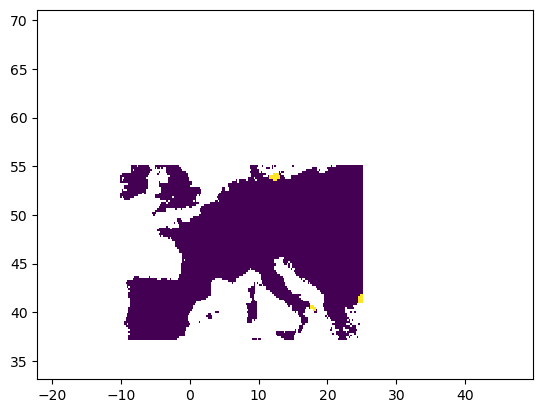

In [88]:
plt.pcolormesh(lons, lats, obs_data[12][:,2].reshape(ny,nx))

In [41]:
print(dates_fcst[12])

['2024050112', '2024050212', '2024050312', '2024050412', '2024050512', '2024050612', '2024050712', '2024050812', '2024050912', '2024051012', '2024051112', '2024051212', '2024051312', '2024051412', '2024051512', '2024051612', '2024051712', '2024051812', '2024051912', '2024052012', '2024052112', '2024052212', '2024052312', '2024052412', '2024052512', '2024052612', '2024052712', '2024052812', '2024052912', '2024053012', '2024053112', '2024060112', '2024060212', '2024060312', '2024060412', '2024060512', '2024060612', '2024060712', '2024060812', '2024060912', '2024061012', '2024061112', '2024061212', '2024061312', '2024061412', '2024061512', '2024061612', '2024061712', '2024061812', '2024061912', '2024062012', '2024062112', '2024062212', '2024062312', '2024062412', '2024062512', '2024062612', '2024062712', '2024062812', '2024062912', '2024063012', '2024070112', '2024070212', '2024070312', '2024070412', '2024070512', '2024070612', '2024070712', '2024070812', '2024070912', '2024071012', '2024

In [20]:
fcst_data_readin_24h[fh].shape

(68400, 153)

In [21]:
# Get indices of all forecasts valid for a certain time.

my_forecasts_for_date = {}

forecast_indices = {}

for i, fh in enumerate(dates_fcst_24h):
    for j, my_date in enumerate(dates_fcst_24h[fh]):
        if my_date not in forecast_indices:
            forecast_indices[my_date] = [(i, j)]
        else:
            forecast_indices[my_date].append((i, j))

            
def AUC(fcst_data, obs_data):
    
    my_fcst_data = fcst_data.flatten()
    my_obs_data  = obs_data.flatten()
    my_fcst_data = fcst_data[~np.isnan(my_fcst_data)]
    my_obs_data  = obs_data[~np.isnan(my_obs_data)]
    
    print('my_fcst_data (min, max, mean)', np.min(my_fcst_data), np.max(my_fcst_data), np.mean(my_fcst_data))
    print('my_obs_data  (min, max, mean)', np.min(my_obs_data),  np.max(my_obs_data),  np.mean(my_obs_data))

    try:
        my_auc = roc_auc_score(my_obs_data, my_fcst_data)
    except ValueError:
        my_auc = np.nan
        pass
    
    return my_auc


auc_scores = np.zeros((len(forecast_indices), 10)) * np.nan

for i, my_date in enumerate(forecast_indices):
    print(my_date)
    for fcst_ids in forecast_indices[my_date]:
        print(fcst_ids)
        fh = 24 * fcst_ids[0] + 6 
        index_fcstnr = fcst_ids[1] 
        
        print(fh, index_fcstnr)
        my_auc = AUC(fcst_data[fh][:, index_fcstnr], obs_data[fh][:, index_fcstnr])
        print(my_auc)
        auc_scores[i, fcst_ids[0]] = my_auc
        
print(auc_scores)




#fh = 30
#index_fcstnr = 0
#my_auc = AUC(fcst_data, obs_data, fh, index_fcstnr)
#
#
#
#print(my_auc)



2024050106
(0, 0)
6 0
my_fcst_data (min, max, mean) 0.0 0.7558703460450256 0.028751767570083426
my_obs_data  (min, max, mean) 0.0 1.0 0.014737883283877349
0.9792620751130753
2024050206
(0, 1)
6 1
my_fcst_data (min, max, mean) 0.0 0.5873502699954608 0.02116565571669123
my_obs_data  (min, max, mean) 0.0 1.0 0.04411473788328388
0.9310187780269058
(1, 0)
30 0
my_fcst_data (min, max, mean) 0.0 0.411159317719914 0.02441996214438342
my_obs_data  (min, max, mean) 0.0 1.0 0.04411473788328388
0.928219335595284
2024050306
(0, 2)
6 2
my_fcst_data (min, max, mean) 0.0 0.1499695989650306 0.00473864907876501
my_obs_data  (min, max, mean) 0.0 1.0 0.004747774480712166
0.9401026137944741
(1, 1)
30 1
my_fcst_data (min, max, mean) 0.0 0.16824947309243765 0.005144651380978887
my_obs_data  (min, max, mean) 0.0 1.0 0.004747774480712166
0.9199173457894387
(2, 0)
54 0
my_fcst_data (min, max, mean) 0.0 0.17819745781634955 0.006959737251916055
my_obs_data  (min, max, mean) 0.0 1.0 0.004747774480712166
0.89066951

my_fcst_data (min, max, mean) 0.0 0.27244640043044066 0.009472974523914006
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.963237020126891
(1, 10)
30 10
my_fcst_data (min, max, mean) 0.0 0.29209984166072267 0.00968778214094621
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.9627376215995516
(2, 9)
54 9
my_fcst_data (min, max, mean) 0.0 0.265855405943597 0.00921355711073116
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.9346137042669647
(3, 8)
78 8
my_fcst_data (min, max, mean) 0.0 0.313947003419929 0.009090750561032278
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.9046770567272839
(4, 7)
102 7
my_fcst_data (min, max, mean) 0.0 0.227247716174118 0.010487858687985884
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.9086968491344313
(5, 6)
126 6
my_fcst_data (min, max, mean) 0.0 0.22702132601092273 0.010516852973731762
my_obs_data  (min, max, mean) 0.0 1.0 0.014935707220573689
0.8494413186781035
(6, 5)
150 5
my_fcst_data (

my_fcst_data (min, max, mean) 0.0 0.39412009161537787 0.03897909725773418
my_obs_data  (min, max, mean) 0.0 1.0 0.001483679525222552
0.31728248307743107
(7, 10)
174 10
my_fcst_data (min, max, mean) 0.0 0.3093229765843347 0.040976031160472555
my_obs_data  (min, max, mean) 0.0 1.0 0.001483679525222552
0.6024203401023609
(8, 9)
198 9
my_fcst_data (min, max, mean) 0.0 0.41802339814932477 0.050748648884073044
my_obs_data  (min, max, mean) 0.0 1.0 0.001483679525222552
0.3500313686643553
2024051906
(0, 18)
6 18
my_fcst_data (min, max, mean) 0.0 0.623821489071948 0.03853594816412871
my_obs_data  (min, max, mean) 0.0 1.0 0.03966369930761622
0.6854294123584848
(1, 17)
30 17
my_fcst_data (min, max, mean) 0.0 0.7386347449519797 0.05347026062153124
my_obs_data  (min, max, mean) 0.0 1.0 0.03966369930761622
0.6458841309539007
(2, 16)
54 16
my_fcst_data (min, max, mean) 0.0 0.803501122854289 0.07677860315895103
my_obs_data  (min, max, mean) 0.0 1.0 0.03966369930761622
0.5591111571159649
(3, 15)
78 15


0.8282267474451673
(4, 20)
102 20
my_fcst_data (min, max, mean) 0.0 0.3830953869462794 0.039573699447786666
my_obs_data  (min, max, mean) 0.0 1.0 0.040850642927794265
0.8334019582702121
(5, 19)
126 19
my_fcst_data (min, max, mean) 0.0 0.2643426247850067 0.036976761423160705
my_obs_data  (min, max, mean) 0.0 1.0 0.040850642927794265
0.8360754592980879
(6, 18)
150 18
my_fcst_data (min, max, mean) 0.0 0.31598059248965593 0.04792079604523524
my_obs_data  (min, max, mean) 0.0 1.0 0.040850642927794265
0.8044513904477584
(7, 17)
174 17
my_fcst_data (min, max, mean) 0.0 0.3292754384533545 0.03862212989837174
my_obs_data  (min, max, mean) 0.0 1.0 0.040850642927794265
0.7839612910410623
(8, 16)
198 16
my_fcst_data (min, max, mean) 0.0 0.26832432218330193 0.029495477380963288
my_obs_data  (min, max, mean) 0.0 1.0 0.040850642927794265
0.7053603108822004
2024052606
(0, 25)
6 25
my_fcst_data (min, max, mean) 0.0 0.390388679716305 0.023919687133871426
my_obs_data  (min, max, mean) 0.0 1.0 0.011770524

0.7769579827406672
(8, 22)
198 22
my_fcst_data (min, max, mean) 0.0 0.22979425149491628 0.024970536108383318
my_obs_data  (min, max, mean) 0.0 1.0 0.013254203758654798
0.7619592993333254
2024060106
(0, 31)
6 31
my_fcst_data (min, max, mean) 0.0 0.6089885346597954 0.031781884192468635
my_obs_data  (min, max, mean) 0.0 1.0 0.03689416419386746
0.8027707803709407
(1, 30)
30 30
my_fcst_data (min, max, mean) 0.0 0.501385455573713 0.02575609615098073
my_obs_data  (min, max, mean) 0.0 1.0 0.03689416419386746
0.8277351172292416
(2, 29)
54 29
my_fcst_data (min, max, mean) 0.0 0.5670187033596026 0.031224213592387598
my_obs_data  (min, max, mean) 0.0 1.0 0.03689416419386746
0.8524070452360899
(3, 28)
78 28
my_fcst_data (min, max, mean) 0.0 0.5577628797237298 0.03040941857838521
my_obs_data  (min, max, mean) 0.0 1.0 0.03689416419386746
0.8101027533514817
(4, 27)
102 27
my_fcst_data (min, max, mean) 0.0 0.4576896281626146 0.03339480731446587
my_obs_data  (min, max, mean) 0.0 1.0 0.03689416419386746


0.7820918167434985
(2, 35)
54 35
my_fcst_data (min, max, mean) 0.0 0.7472283994796735 0.07133493372242634
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.7858794818972759
(3, 34)
78 34
my_fcst_data (min, max, mean) 0.0 0.7012510605054696 0.06005419182606939
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.7576708753484147
(4, 33)
102 33
my_fcst_data (min, max, mean) 0.0 0.6410097148673104 0.06014120189691221
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.8012880213605318
(5, 32)
126 32
my_fcst_data (min, max, mean) 0.0 0.5153705416703631 0.06422790026461618
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.7514020075218992
(6, 31)
150 31
my_fcst_data (min, max, mean) 0.0 0.6989123006923028 0.060021049727863485
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.6367884027985977
(7, 30)
174 30
my_fcst_data (min, max, mean) 0.0 0.4350280150500946 0.07037274119193818
my_obs_data  (min, max, mean) 0.0 1.0 0.027101879327398614
0.534

0.94260924367769
(6, 37)
150 37
my_fcst_data (min, max, mean) 0.0 0.6724210186965365 0.05093724079265521
my_obs_data  (min, max, mean) 0.0 1.0 0.034421364985163204
0.8978285199236071
(7, 36)
174 36
my_fcst_data (min, max, mean) 0.0 0.6365462967717606 0.054235850158085394
my_obs_data  (min, max, mean) 0.0 1.0 0.034421364985163204
0.9233453020979779
(8, 35)
198 35
my_fcst_data (min, max, mean) 1.9634470571627816e-07 0.5118537979165831 0.03069415081146208
my_obs_data  (min, max, mean) 0.0 1.0 0.034421364985163204
0.9157177903058306
2024061406
(0, 44)
6 44
my_fcst_data (min, max, mean) 0.0 0.7234456584749065 0.006252871518797827
my_obs_data  (min, max, mean) 0.0 1.0 0.0012858555885262117
0.996765985326944
(1, 43)
30 43
my_fcst_data (min, max, mean) 0.0 0.840530936509659 0.008943406565806071
my_obs_data  (min, max, mean) 0.0 1.0 0.0012858555885262117
0.9879514859706995
(2, 42)
54 42
my_fcst_data (min, max, mean) 0.0 0.8907992141506794 0.012393598938650744
my_obs_data  (min, max, mean) 0.0 1

0.8505269227448277
(8, 41)
198 41
my_fcst_data (min, max, mean) 2.6127586010171733e-05 0.7317618682017664 0.08915289637928947
my_obs_data  (min, max, mean) 0.0 1.0 0.020474777448071215
0.7771899502468631
2024062006
(0, 50)
6 50
my_fcst_data (min, max, mean) 0.0 0.9121926799180898 0.04844182751162482
my_obs_data  (min, max, mean) 0.0 1.0 0.004846686449060336
0.8382529833322853
(1, 49)
30 49
my_fcst_data (min, max, mean) 0.0 0.8068499967713717 0.045269673501503044
my_obs_data  (min, max, mean) 0.0 1.0 0.004846686449060336
0.8603244697143344
(2, 48)
54 48
my_fcst_data (min, max, mean) 0.0 0.696869840246285 0.04389103476845527
my_obs_data  (min, max, mean) 0.0 1.0 0.004846686449060336
0.848533131570887
(3, 47)
78 47
my_fcst_data (min, max, mean) 0.0 0.7097986753128166 0.05796365397458906
my_obs_data  (min, max, mean) 0.0 1.0 0.004846686449060336
0.8185223199706282
(4, 46)
102 46
my_fcst_data (min, max, mean) 0.0 0.6678182363711638 0.07328382620671574
my_obs_data  (min, max, mean) 0.0 1.0 0

0.838708785956337
(3, 53)
78 53
my_fcst_data (min, max, mean) 0.0 0.8490994352583718 0.07015772218823518
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480712166174
0.829762028422047
(4, 52)
102 52
my_fcst_data (min, max, mean) 0.0 0.7622552113052566 0.062218831986510736
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480712166174
0.8196913614895649
(5, 51)
126 51
my_fcst_data (min, max, mean) 0.0 0.7017415965860544 0.0543095017705205
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480712166174
0.7999414388578019
(6, 50)
150 50
my_fcst_data (min, max, mean) 0.0 0.479232242261301 0.05776919636574389
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480712166174
0.7493913232732043
(7, 49)
174 49
my_fcst_data (min, max, mean) 1.753076415478283e-06 0.5018157954848376 0.06238629119373388
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480712166174
0.7934496039757057
(8, 48)
198 48
my_fcst_data (min, max, mean) 0.0 0.3566015976129687 0.04990129882413813
my_obs_data  (min, max, mean) 0.0 1.0 0.047774480

0.9624367084265268
(1, 61)
30 61
my_fcst_data (min, max, mean) 0.0 0.9138823335642536 0.03543581479215809
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.9534815511066591
(2, 60)
54 60
my_fcst_data (min, max, mean) 0.0 0.8814489690467745 0.036223018630109995
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.9468556609081055
(3, 59)
78 59
my_fcst_data (min, max, mean) 0.0 0.7952230769679743 0.03592640085413346
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.9303381039285371
(4, 58)
102 58
my_fcst_data (min, max, mean) 0.0 0.7794483738636916 0.03619858770089528
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.9210913594138068
(5, 57)
126 57
my_fcst_data (min, max, mean) 0.0 0.7150658221031244 0.041135726840122275
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.9202063065164593
(6, 56)
150 56
my_fcst_data (min, max, mean) 0.0 0.7314091878399271 0.041120672305857864
my_obs_data  (min, max, mean) 0.0 1.0 0.005736894164193867
0.91

my_fcst_data (min, max, mean) 0.0 0.4723179620841115 0.01948713693708859
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.9434714171497102
(2, 66)
54 66
my_fcst_data (min, max, mean) 0.0 0.35118550023820505 0.017237260886504385
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.9326490644075094
(3, 65)
78 65
my_fcst_data (min, max, mean) 0.0 0.39331791722706244 0.022114474694527958
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.9267449145897078
(4, 64)
102 64
my_fcst_data (min, max, mean) 0.0 0.41224620296813586 0.023777106692890734
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.9165961961284768
(5, 63)
126 63
my_fcst_data (min, max, mean) 0.0 0.36572895447250564 0.02073406042000083
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.8696906855886468
(6, 62)
150 62
my_fcst_data (min, max, mean) 0.0 0.1707749453280477 0.029316639586267228
my_obs_data  (min, max, mean) 0.0 1.0 0.010286844708209694
0.9140275450114547
(7, 61)
174 6

0.8897879721892041
(7, 66)
174 66
my_fcst_data (min, max, mean) 0.0 0.7657052896983512 0.07209694295645049
my_obs_data  (min, max, mean) 0.0 1.0 0.027794263105835805
0.9087988228602338
(8, 65)
198 65
my_fcst_data (min, max, mean) 0.0 0.739222322822185 0.07971187548677808
my_obs_data  (min, max, mean) 0.0 1.0 0.027794263105835805
0.8773590678176896
2024071406
(0, 74)
6 74
my_fcst_data (min, max, mean) 0.0 0.7002486907495733 0.03334589356241274
my_obs_data  (min, max, mean) 0.0 1.0 0.010089020771513354
0.9413665146314322
(1, 73)
30 73
my_fcst_data (min, max, mean) 0.0 0.5927047799624684 0.03513315829080403
my_obs_data  (min, max, mean) 0.0 1.0 0.010089020771513354
0.9202069716775598
(2, 72)
54 72
my_fcst_data (min, max, mean) 0.0 0.573670530657423 0.026637745153554642
my_obs_data  (min, max, mean) 0.0 1.0 0.010089020771513354
0.911063306217771
(3, 71)
78 71
my_fcst_data (min, max, mean) 0.0 0.568416763684263 0.031278148992075185
my_obs_data  (min, max, mean) 0.0 1.0 0.010089020771513354


0.8150169970211127
(5, 75)
126 75
my_fcst_data (min, max, mean) 0.0 0.4675436238171682 0.03220122333394838
my_obs_data  (min, max, mean) 0.0 1.0 0.01463897131552918
0.7696934160621172
(6, 74)
150 74
my_fcst_data (min, max, mean) 0.0 0.49426446879629904 0.036577995422558025
my_obs_data  (min, max, mean) 0.0 1.0 0.01463897131552918
0.5932248625859347
(7, 73)
174 73
my_fcst_data (min, max, mean) 0.0 0.4364211198412141 0.036448497093753154
my_obs_data  (min, max, mean) 0.0 1.0 0.01463897131552918
0.8044538842194935
(8, 72)
198 72
my_fcst_data (min, max, mean) 0.0 0.5172898240356432 0.04162312481364752
my_obs_data  (min, max, mean) 0.0 1.0 0.01463897131552918
0.8082473534566488
2024072106
(0, 81)
6 81
my_fcst_data (min, max, mean) 0.0 0.8861438532396987 0.0254086865001891
my_obs_data  (min, max, mean) 0.0 1.0 0.023837784371909
0.8847279023254426
(1, 80)
30 80
my_fcst_data (min, max, mean) 0.0 0.9066033983922628 0.03330410494170294
my_obs_data  (min, max, mean) 0.0 1.0 0.023837784371909
0.84

my_fcst_data (min, max, mean) 0.0 0.47109603855849325 0.021895439987310333
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.9102048947068868
(2, 86)
54 86
my_fcst_data (min, max, mean) 0.0 0.43654495826890305 0.02249799189569631
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.8990893568582812
(3, 85)
78 85
my_fcst_data (min, max, mean) 0.0 0.3403462653676941 0.0225797925675154
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.8566661923733636
(4, 84)
102 84
my_fcst_data (min, max, mean) 0.0 0.37523425057159543 0.03173607973743884
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.6807541263517359
(5, 83)
126 83
my_fcst_data (min, max, mean) 0.0 0.3833080166055449 0.019788783615004933
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.7918355150825269
(6, 82)
150 82
my_fcst_data (min, max, mean) 0.0 0.32247493712346864 0.02792666169833791
my_obs_data  (min, max, mean) 0.0 1.0 0.006923837784371909
0.779359704040979
(7, 81)
174 81
my

0.9663301682492087
2024080406
(0, 95)
6 95
my_fcst_data (min, max, mean) 0.0 0.649990231663833 0.011056670295427156
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(1, 94)
30 94
my_fcst_data (min, max, mean) 0.0 0.5484936358197805 0.00924148887615102
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(2, 93)
54 93
my_fcst_data (min, max, mean) 0.0 0.281877961144102 0.00803322301373476
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(3, 92)
78 92
my_fcst_data (min, max, mean) 0.0 0.19293009019722251 0.007059910928067541
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(4, 91)
102 91
my_fcst_data (min, max, mean) 0.0 0.24735841952954007 0.008411794949547026
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(5, 90)
126 90
my_fcst_data (min, max, mean) 0.0 0.2755850816515313 0.007946660927400019
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(6, 89)
150 89
my_fcst_data (min, max, mean) 0.0 0.26548402251337966 0.010850337702483765
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(7, 88)
174 88
my_fcst_data (mi

my_fcst_data (min, max, mean) 0.0 0.6802310402034932 0.10660824342164155
my_obs_data  (min, max, mean) 0.0 1.0 0.06973293768545995
0.8303766293016013
(5, 99)
126 99
my_fcst_data (min, max, mean) 0.0 0.5491896192664236 0.09130251966910964
my_obs_data  (min, max, mean) 0.0 1.0 0.06973293768545995
0.8336050312758039
(6, 98)
150 98
my_fcst_data (min, max, mean) 1.9634470571627816e-07 0.6134388212364519 0.10636027500822381
my_obs_data  (min, max, mean) 0.0 1.0 0.06973293768545995
0.7947055474491085
(7, 97)
174 97
my_fcst_data (min, max, mean) 0.0 0.5426808778253593 0.07891512205437606
my_obs_data  (min, max, mean) 0.0 1.0 0.06973293768545995
0.7834120224265801
(8, 96)
198 96
my_fcst_data (min, max, mean) 0.0 0.28208834682845596 0.03899461779794246
my_obs_data  (min, max, mean) 0.0 1.0 0.06973293768545995
0.6750285987911967
2024081406
(0, 105)
6 105
my_fcst_data (min, max, mean) 0.0 0.8448839032892261 0.04387599215849005
my_obs_data  (min, max, mean) 0.0 1.0 0.021167161226508406
0.8458668753

my_fcst_data (min, max, mean) 0.0 0.7590125811919667 0.007117529838714845
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.9238418326918723
(2, 111)
54 111
my_fcst_data (min, max, mean) 0.0 0.6295038337467791 0.009342143612101188
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.9320841351596106
(3, 110)
78 110
my_fcst_data (min, max, mean) 0.0 0.4928346354346006 0.008621033601142004
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.9681592426986643
(4, 109)
102 109
my_fcst_data (min, max, mean) 0.0 0.4093705636132222 0.009440163010430784
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.9444794260810505
(5, 108)
126 108
my_fcst_data (min, max, mean) 0.0 0.2393162229890019 0.008804988554019268
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.9202972888838579
(6, 107)
150 107
my_fcst_data (min, max, mean) 0.0 0.25952326164500483 0.011870075091159551
my_obs_data  (min, max, mean) 0.0 1.0 0.0013847675568743817
0.889252462078333

my_fcst_data (min, max, mean) 0.0 0.6265048574608726 0.06243962736783772
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.8516160053081906
(3, 119)
78 119
my_fcst_data (min, max, mean) 0.0 0.798711663856041 0.0751915950019961
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.8348237485847918
(4, 118)
102 118
my_fcst_data (min, max, mean) 0.0 0.6463494767990365 0.06458652075728824
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.8433347176079735
(5, 117)
126 117
my_fcst_data (min, max, mean) 1.9634470571627816e-07 0.5966114406382169 0.06188660314716297
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.7790204671578909
(6, 116)
150 116
my_fcst_data (min, max, mean) 0.0 0.4490804321445614 0.0411084404391639
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.5510849542493365
(7, 115)
174 115
my_fcst_data (min, max, mean) 0.0 0.3684907551590675 0.0450515797244997
my_obs_data  (min, max, mean) 0.0 1.0 0.008506429277942632
0.599575553555

my_fcst_data (min, max, mean) 0.0 0.6576727539180871 0.018952584588525546
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.9658027045769764
(3, 127)
78 127
my_fcst_data (min, max, mean) 0.0 0.3926998213208178 0.026085667835295447
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.9069744402615414
(4, 126)
102 126
my_fcst_data (min, max, mean) 0.0 0.5918735909674981 0.04168288931782267
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.9006835744006341
(5, 125)
126 125
my_fcst_data (min, max, mean) 0.0 0.5646182495528156 0.05699882469565438
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.8630807905686546
(6, 124)
150 124
my_fcst_data (min, max, mean) 0.0 0.4320631182487207 0.048967574776744946
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.8644182187438082
(7, 123)
174 123
my_fcst_data (min, max, mean) 0.0 0.3531467398567544 0.044092840317505703
my_obs_data  (min, max, mean) 0.0 1.0 0.001582591493570722
0.8440533980582525
(8, 12

my_fcst_data (min, max, mean) 0.0 0.23031678855353488 0.011593127727955989
my_obs_data  (min, max, mean) 0.0 1.0 0.0035608308605341245
0.9589206538283369
(7, 134)
174 134
my_fcst_data (min, max, mean) 0.0 0.15665918114187605 0.009915676558886886
my_obs_data  (min, max, mean) 0.0 1.0 0.0035608308605341245
0.9531660159265877
(8, 133)
198 133
my_fcst_data (min, max, mean) 0.0 0.13330483731615672 0.008227626609807864
my_obs_data  (min, max, mean) 0.0 1.0 0.0035608308605341245
0.9428203516202325
2024092006
(0, 142)
6 142
my_fcst_data (min, max, mean) 0.0 0.40508647519828467 0.016852365535650383
my_obs_data  (min, max, mean) 0.0 1.0 0.008704253214638972
0.9602703597539957
(1, 141)
30 141
my_fcst_data (min, max, mean) 0.0 0.3652746472128451 0.017780336216384952
my_obs_data  (min, max, mean) 0.0 1.0 0.008704253214638972
0.9366711416701439
(2, 140)
54 140
my_fcst_data (min, max, mean) 0.0 0.38783785469467447 0.018204042507942508
my_obs_data  (min, max, mean) 0.0 1.0 0.008704253214638972
0.93023

my_fcst_data (min, max, mean) 0.0 0.18343922196826867 0.004503762625147798
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(2, 146)
54 146
my_fcst_data (min, max, mean) 0.0 0.20635207083510398 0.007393045337430627
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(3, 145)
78 145
my_fcst_data (min, max, mean) 0.0 0.11245881060794571 0.006374724743123687
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(4, 144)
102 144
my_fcst_data (min, max, mean) 0.0 0.08746148387609776 0.004598302858553661
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(5, 143)
126 143
my_fcst_data (min, max, mean) 0.0 0.10791385544254584 0.005386473825292199
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(6, 142)
150 142
my_fcst_data (min, max, mean) 0.0 0.06433861068928448 0.007647787055067474
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(7, 141)
174 141
my_fcst_data (min, max, mean) 0.0 0.0924598938984692 0.008111915252993469
my_obs_data  (min, max, mean) 0.0 0.0 0.0
nan
(8, 140)
198 140
my_fcst_data (min, max, mean) 0.0 0.0

In [22]:
corr = 0.48

def BSS(fcst_data, obs_data, ref_data):
    
    my_fcst_data = fcst_data.flatten()
    my_obs_data  = obs_data.flatten()
    my_ref_data  = ref_data.flatten()
    
    my_fcst_data = my_fcst_data[~np.isnan(my_fcst_data)]
    my_obs_data  = my_obs_data[~np.isnan(my_obs_data)]
    my_ref_data  = my_ref_data[~np.isnan(my_ref_data)]
    
    print('my_fcst_data (shape, min, max, mean)', my_fcst_data.shape, np.min(my_fcst_data), np.max(my_fcst_data), np.mean(my_fcst_data))
    print('my_obs_data  (shape, min, max, mean)', my_obs_data.shape,  np.min(my_obs_data),  np.max(my_obs_data),  np.mean(my_obs_data))
    print('my_ref_data  (shape, min, max, mean)', my_ref_data.shape,  np.min(my_ref_data),  np.max(my_ref_data),  np.mean(my_ref_data))
    try:
        my_auc = roc_auc_score(my_obs_data, my_fcst_data)
    except ValueError:
        my_auc = np.nan
        pass

#    my_obs_freq  =   np.sum(my_obs_data)/my_obs_data.shape[0]
#   my_fcst_freq =   np.sum(forecast1d[fh] * corr)/(forecast1d[fh] * corr).shape[0]
#    fcst_freq.append (my_fcst_freq)
#
#    print(fh, 'obs:', my_obs_freq, 'fcst:', my_fcst_freq, my_fcst_freq/my_obs_freq)
#    
#    bias.append      ((my_fcst_freq - my_obs_freq) / my_obs_freq)

    bs          =    brier_score_loss(my_obs_data, my_fcst_data * corr)
    bs_ref      =    brier_score_loss(my_obs_data, my_ref_data)
    bss         =    1 - (bs / bs_ref)

    return bss

print(obs_data[6].shape)
obs_freq   = np.mean(obs_data[6], axis = 1)

print('obs_freq.shape', obs_freq.shape)

ref_data   = obs_freq
bss_scores = np.zeros((len(forecast_indices), 10)) * np.nan


for i, my_date in enumerate(forecast_indices):
    print(my_date)
    for fcst_ids in forecast_indices[my_date]:
        print(fcst_ids)
        fh = 24 * fcst_ids[0] + 6 
        index_fcstnr = fcst_ids[1] 
        
        print(fh, index_fcstnr)
        my_bss = BSS(fcst_data[fh][:, index_fcstnr], obs_data[fh][:, index_fcstnr], ref_data)
        print(my_bss)
        bss_scores[i, fcst_ids[0]] = my_bss


(68400, 153)
obs_freq.shape (68400,)
2024050106
(0, 0)
6 0
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7558703460450256 0.028751767570083426
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.014737883283877349
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.2032233266402449
2024050206
(0, 1)
6 1
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5873502699954608 0.02116565571669123
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.04411473788328388
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.07431539322682201
(1, 0)
30 0
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.411159317719914 0.02441996214438342
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.04411473788328388
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.06426567701332031
2024050306
(0, 2)
6 2
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.14996959896

0.08844307549742669
(7, 0)
174 0
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.1363091957464838 0.017085027329861672
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.005044510385756677
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.05395339377359254
2024050906
(0, 8)
6 8
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.607193534902442 0.002930055986543467
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.002176063303659743
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.14769773623731186
(1, 7)
30 7
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.551026479065697 0.0028732468306629103
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.002176063303659743
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.14872240511942647
(2, 6)
54 6
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4022180368772713 0.002073472418058097
my_o

0.002768843218799999
(7, 4)
174 4
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4010399099278067 0.017882135998304724
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.014935707220573689
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.007538926736417206
(8, 3)
198 3
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.15769098398935644 0.008054620735860179
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.014935707220573689
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-8.26286910753371e-05
2024051306
(0, 12)
6 12
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7429498712386033 0.004841865982158343
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004549950544015826
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.025667575019852507
(1, 11)
30 11
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5048866560420606 0.0045801191

0.06852793251598532
(4, 11)
102 11
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4308478944316234 0.03419583396347952
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0314540059347181
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.06499828852646794
(5, 10)
126 10
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5135487044302962 0.0319710674816722
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0314540059347181
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.0707195557993553
(6, 9)
150 9
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.37259387241340314 0.03357290275508119
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0314540059347181
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.013233871357477334
(7, 8)
174 8
my_fcst_data (shape, min, max, mean) (10110,) 1.7460640617805723e-06 0.2860761953819666 0.034071272718665

-0.003357019337105527
(4, 16)
102 16
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.819249213188165 0.0645796660464983
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0162215628090999
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.011415723869269812
(5, 15)
126 15
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.8224808979147946 0.060663651711015114
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0162215628090999
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.0022388814041602867
(6, 14)
150 14
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7493842083210025 0.0485961305900443
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0162215628090999
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.01590238301944158
(7, 13)
174 13
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7363436311911822 0.05812921007343175
my_obs

0.02774750202561349
(2, 22)
54 22
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.44870209514053894 0.04692207261639176
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.040850642927794265
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.033646936749231804
(3, 21)
78 21
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4269460093486842 0.03881366360283092
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.040850642927794265
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.030473213590619275
(4, 20)
102 20
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3830953869462794 0.039573699447786666
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.040850642927794265
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.029142919008069756
(5, 19)
126 19
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2643426247850067 0.036976761423160705
my

0.12960188499616976
(1, 28)
30 28
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4203469980431195 0.026840722240766442
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.020969337289812068
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11344196855501343
(2, 27)
54 27
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3814161618512366 0.02494308329040354
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.020969337289812068
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.10922785243191202
(3, 26)
78 26
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3610532559357741 0.02662409474749506
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.020969337289812068
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11035216505081735
(4, 25)
102 25
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3037879102661514 0.019412924516287625
my_obs_

-0.024690231756658854
(7, 27)
174 27
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7059675578879572 0.05211661032245796
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.009198813056379823
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.08092952256844144
(8, 26)
198 26
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6735737454891685 0.0450746529113805
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.009198813056379823
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.05860706765185464
2024060506
(0, 35)
6 35
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.735088304672122 0.011689487547611553
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.00741839762611276
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.10202680777102247
(1, 34)
30 34
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.8623539785688912 0.01286789060897

-0.06474943054825166
(3, 35)
78 35
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7636499031970667 0.05928323983394677
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.027398615232443125
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.04773112883128072
(4, 34)
102 34
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7432500767243407 0.05681762017055191
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.027398615232443125
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.03879479927403118
(5, 33)
126 33
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7756540298143034 0.062429243319489396
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.027398615232443125
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.03955707642679562
(6, 32)
150 32
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7789929427822694 0.0760119882829509
my_

-0.03791621807146228
(4, 37)
102 37
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.42529586785392504 0.0209582508279184
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.008605341246290801
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.012251089178347496
(5, 36)
126 36
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5979742351791522 0.029731098551608062
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.008605341246290801
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.031906849615469746
(6, 35)
150 35
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6806744355338782 0.046355052557014824
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.008605341246290801
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.20485658324614264
(7, 34)
174 34
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6191292659867137 0.05442874742239427

-0.059071488307139486
(8, 38)
198 38
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3737580718389327 0.0306712941185833
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0076162215628091
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.059636494284367014
2024061706
(0, 47)
6 47
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.42202477781746406 0.021990209087239844
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0034619188921859545
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.1666649749717547
(1, 46)
30 46
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.33691506260299575 0.02199804941775372
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0034619188921859545
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.12106421354580088
(2, 45)
54 45
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.41322112505421627 0.02129984636

0.18967230378703492
(6, 46)
150 46
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.8683644416188829 0.11522936131693634
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.04727992087042532
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.16815339418651376
(7, 45)
174 45
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6446532352478003 0.07985078401122632
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.04727992087042532
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.14100498599508904
(8, 44)
198 44
my_fcst_data (shape, min, max, mean) (10110,) 7.783662624438747e-07 0.45995044124916984 0.052146841827685045
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.04727992087042532
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.09131717359840907
2024062306
(0, 53)
6 53
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.9655942014324838 

0.02120319468061649
(3, 55)
78 55
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5696593518763473 0.05783132587772818
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.018793273986152326
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.0444056110656722
(4, 54)
102 54
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4948481575265061 0.05732642331010544
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.018793273986152326
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.02984868439439392
(5, 53)
126 53
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.39512823693218 0.05772245614735749
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.018793273986152326
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.008152497524830604
(6, 52)
150 52
my_fcst_data (shape, min, max, mean) (10110,) 3.9268937290781736e-07 0.38375613075622816 0.058419

0.08307692726853877
(7, 54)
174 54
my_fcst_data (shape, min, max, mean) (10110,) 1.1640430492843024e-06 0.5319923353564832 0.06075298370569012
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.03432245301681503
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11804662695377555
(8, 53)
198 53
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3266529819037609 0.044872014410466426
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.03432245301681503
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.05512326953995117
2024070206
(0, 62)
6 62
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.9350100511844899 0.030673893069602887
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.005736894164193867
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.03403503780396311
(1, 61)
30 61
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.913882333564253

0.21304716619319752
(7, 58)
174 58
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.24133104512683345 0.01021339240498397
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.001582591493570722
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.19966556886820153
(8, 57)
198 57
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.17371351849874206 0.009716040395446702
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.001582591493570722
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.18816754671372438
2024070606
(0, 66)
6 66
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5309469379039102 0.018322265459936184
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.011968348170128585
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.005375760490811121
(1, 65)
30 65
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5945690528109311 0.01965872765

0.08295403182430094
(5, 65)
126 65
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6276651991785225 0.0756921621394142
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.058951533135509396
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.1410229220422068
(6, 64)
150 64
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.41919507263033373 0.07044626322654915
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.058951533135509396
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.09748552510178721
(7, 63)
174 63
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5315968692428799 0.07249023761158008
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.058951533135509396
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.008790151430964954
(8, 62)
198 62
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.30872996494072835 0.045103205912385244
my_

0.053082420790614204
(7, 69)
174 69
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.34747375105417977 0.04291723426699668
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.03402571711177053
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.028521768185313934
(8, 68)
198 68
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.269475231469681 0.03757308661238367
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.03402571711177053
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.0021853429482757702
2024071706
(0, 77)
6 77
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7827190214678169 0.046509592028285536
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.020375865479723046
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11441776024697292
(1, 76)
30 76
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7786805272115355 0.0411245092882

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.18122014917487295 0.010529958008439809
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004648862512363996
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.03847519414240175
(8, 74)
198 74
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.17601408322723444 0.014550292945480985
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004648862512363996
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.03385943307335537
2024072306
(0, 83)
6 83
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.30382476135502645 0.02431680522744766
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.009099901088031652
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.041524834751117456
(1, 82)
30 82
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.34013580884201033 0.02155356210893771
my_obs_data  (shape, min, 

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.33576017032621863 0.009790684705566526
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004253214638971316
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.04729166737201662
(1, 86)
30 86
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3916257295592598 0.010073632414138405
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004253214638971316
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.061172102062685085
(2, 85)
54 85
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.37872492267157765 0.011233664201741931
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.004253214638971316
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.0469192848056158
(3, 84)
78 84
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2582077806360581 0.011381960337924551
my_obs_data  (shape, min, max, mean) (

-0.2704439829501428
(4, 86)
102 86
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6206816360307537 0.04589345488904296
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.006726013847675569
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.06697410960940542
(5, 85)
126 85
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6416399685032418 0.052327891982991245
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.006726013847675569
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.10796918645524434
(6, 84)
150 84
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4116450025913667 0.04798293945660084
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.006726013847675569
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.02498347403184975
(7, 83)
174 83
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3817719082324521 0.038151462392814306
m

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.44734410519424683 0.006031461548166735
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0012858555885262117
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.215593900472294
(2, 94)
54 94
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.35282759834726685 0.0063842034618264935
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0012858555885262117
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.21170676735253202
(3, 93)
78 93
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.29828316962008317 0.007730783164535661
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0012858555885262117
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.2022011954514742
(4, 92)
102 92
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.24048155778063218 0.004958606316423266
my_obs_data  (shape, min, max, mea

0.10634257463351104
(1, 101)
30 101
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6112937616001 0.015630292503698264
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.001483679525222552
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.03969117406391176
(2, 100)
54 100
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4435571213238816 0.013135431275605926
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.001483679525222552
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.07442851603581657
(3, 99)
78 99
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4400082011806373 0.018532073899499697
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.001483679525222552
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.012728001177788384
(4, 98)
102 98
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3956219399340025 0.014773644355507532
my

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.6960429252083282 0.06258886519369217
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.021167161226508406
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.08886186043743849
(3, 102)
78 102
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.7224873568368153 0.06548771854186669
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.021167161226508406
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.0930377358365746
(4, 101)
102 101
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5226890474422505 0.06034251555078363
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.021167161226508406
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.07611513280815885
(5, 100)
126 100
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.48042449449819014 0.05537254227847696
my_obs_data  (shape, min, max, me

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.36994030598390204 0.04479562076589612
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.01562809099901088
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.023592363985036058
(5, 104)
126 104
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4208156535756513 0.04115860975552261
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.01562809099901088
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.012148110852346572
(6, 103)
150 103
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3228775736063797 0.03914996582346414
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.01562809099901088
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.00898485343136779
(7, 102)
174 102
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2707282003186763 0.035427823489894227
my_obs_data  (shape, min, max, mea

0.17656261200656642
(7, 106)
174 106
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2647206388548583 0.011859051215877348
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0013847675568743817
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.1551372590040634
(8, 105)
198 105
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2862716208859455 0.017601903052915414
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.0013847675568743817
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.1367849947906371
2024082306
(0, 114)
6 114
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.37362095792492067 0.004739100285845065
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.7455325451539899
(1, 113)
30 113
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3548848531859343 0.0042063615525519595
my

-0.04500724215670271
(6, 113)
150 113
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5723153731249395 0.03452442267431031
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.010385756676557863
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.019735274200716635
(7, 112)
174 112
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.47268095521724385 0.033411017755719336
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.010385756676557863
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.026753122512301886
(8, 111)
198 111
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4361163279583674 0.020591756066256628
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.010385756676557863
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.008178219172981338
2024082906
(0, 120)
6 120
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.8711586907863096

0.04231463663457791
(2, 123)
54 123
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.691340038559868 0.026852050384134494
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.011671612265084076
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.03286103183399769
(3, 122)
78 122
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5249406513392638 0.023163061100343385
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.011671612265084076
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.023208296386383886
(4, 121)
102 121
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4764280013403315 0.027582794551022582
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.011671612265084076
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.0025900111874337384
(5, 120)
126 120
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.35762091205404545 0.024142943782

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.36949955183617045 0.007273187700723882
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.6568302377075536
(2, 129)
54 129
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.41664128347779383 0.00969807343490722
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.5049536836645803
(3, 128)
78 128
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.40541429284453967 0.009368882775062813
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.5291426369154014
(4, 127)
102 127
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3000469291977428 0.013041072963093724
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, m

my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.35193538287714576
(6, 128)
150 128
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3311034648847291 0.014969413870706364
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.27663809209379175
(7, 127)
174 127
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.35484846351753696 0.01784636339658653
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.23825733602383004
(8, 126)
198 126
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.3785499560227803 0.02016918254136116
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11377778371069724
2024091306
(0, 135)
6 135
my_fcst_data (shape, min, max, mean)

0.9737181411726277
(8, 130)
198 130
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.06578868428600226 0.0028280156669624815
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.985623926865597
2024091706
(0, 139)
6 139
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5429310369922528 0.004032396224229105
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.5777113277130934
(1, 138)
30 138
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4674945347425732 0.004029596180033181
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.7106139365672723
(2, 137)
54 137
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.42256721190283153 0.004003360031631203
my_obs_data  (shape, min, max, mean) (10

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.18293391214057397 0.005964226245151802
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.8517602361881863
(3, 141)
78 141
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.16014521216910838 0.0073506699805128955
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.8120431283625361
(4, 140)
102 140
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.10391326380219079 0.006909103500923917
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.8788433335973277
(5, 139)
126 139
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.1458799303267152 0.010088229069423893
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.39382470350308807 0.004323671355062297
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.002967359050445104
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.1441575949363857
(2, 147)
54 147
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.25529731453541604 0.004682042231852886
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.002967359050445104
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.11755362862829777
(3, 146)
78 146
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.2955356038624871 0.005581291452352937
my_obs_data  (shape, min, max, mean) (10110,) 0.0 1.0 0.002967359050445104
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.14122068646400954
(4, 145)
102 145
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.36538670522348593 0.006637475373173348
my_obs_data  (shape, min, max, 

my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.23762247320112573 0.00667778971548092
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.8068574399710234
(8, 149)
198 149
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.15624675649966113 0.008229633661161306
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
0.8337956762262133
2024100606
(6, 152)
150 152
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.5195439028682298 0.013060727277156427
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  (shape, min, max, mean) (10110,) 0.0 0.11764705882352941 0.013807593594641947
-0.11227790052716502
(7, 151)
174 151
my_fcst_data (shape, min, max, mean) (10110,) 0.0 0.4626332811529966 0.012758438672166911
my_obs_data  (shape, min, max, mean) (10110,) 0.0 0.0 0.0
my_ref_data  

In [23]:
print(obs_data)

{6: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 30: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 54: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 78: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
      

In [39]:
number = []

for i, my_date in enumerate(forecast_indices):
    print(my_date, end = ' ')
    index_fcstnr = forecast_indices[my_date][0][1]
    print(np.count_nonzero(obs_data[6][:, index_fcstnr] == 1))
    number.append(np.count_nonzero(obs_data[6][:, index_fcstnr] == 1))


2024050106 149
2024050206 446
2024050306 48
2024050406 51
2024050506 181
2024050606 110
2024050706 17
2024050806 51
2024050906 22
2024051006 0
2024051106 9
2024051206 151
2024051306 46
2024051406 16
2024051506 105
2024051606 318
2024051706 166
2024051806 15
2024051906 401
2024052006 402
2024052106 164
2024052206 289
2024052306 100
2024052406 292
2024052506 413
2024052606 119
2024052706 153
2024052806 126
2024052906 48
2024053006 212
2024053106 134
2024060106 373
2024060206 311
2024060306 237
2024060406 93
2024060506 75
2024060606 223
2024060706 274
2024060806 277
2024060906 290
2024061006 212
2024061106 87
2024061206 162
2024061306 348
2024061406 13
2024061506 46
2024061606 77
2024061706 35
2024061806 283
2024061906 207
2024062006 49
2024062106 517
2024062206 478
2024062306 199
2024062406 59
2024062506 148
2024062606 483
2024062706 541
2024062806 190
2024062906 239
2024063006 401
2024070106 347
2024070206 58
2024070306 7
2024070406 5
2024070506 16
2024070606 121
2024070706 110
20240708

In [25]:
print(number)

[149, 446, 48, 51, 181, 110, 17, 51, 22, 0, 9, 151, 46, 16, 105, 318, 166, 15, 401, 402, 164, 289, 100, 292, 413, 119, 153, 126, 48, 212, 134, 373, 311, 237, 93, 75, 223, 274, 277, 290, 212, 87, 162, 348, 13, 46, 77, 35, 283, 207, 49, 517, 478, 199, 59, 148, 483, 541, 190, 239, 401, 347, 58, 7, 5, 16, 121, 110, 104, 162, 596, 696, 700, 281, 102, 112, 344, 206, 26, 52, 148, 241, 47, 92, 84, 0, 0, 43, 70, 60, 68, 275, 246, 176, 105, 0, 13, 29, 370, 58, 0, 0, 15, 175, 705, 214, 27, 75, 111, 158, 0, 143, 62, 14, 0, 53, 63, 152, 294, 105, 55, 49, 86, 180, 132, 118, 118, 57, 31, 79, 16, 0, 20, 24, 0, 0, 0, 0, 0, 0, 0, 36, 88, 0, 0, 0, 0, 0, 0, 30, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


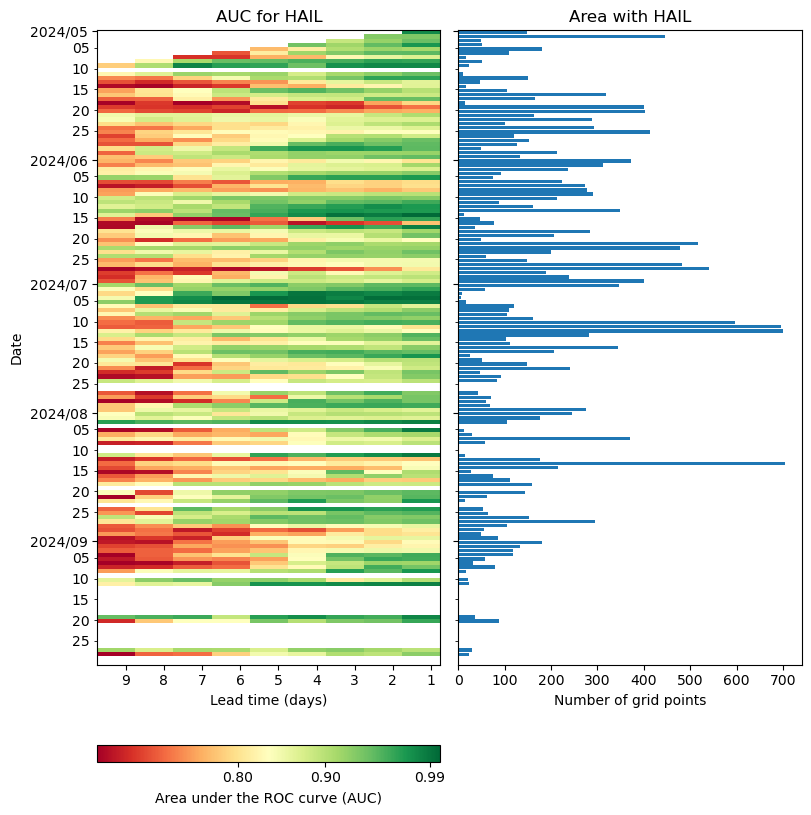

In [26]:
import datetime as dt
import matplotlib.dates as mdates

dates  = [dt.datetime.strptime(mytimestr, '%Y%m%d%H') for mytimestr in dates_fcst_24h[6]]

my_fh, my_dates = np.meshgrid(np.arange(0, auc_scores.shape[1]) * 24 + 6, dates)

#print(len(dates), len(number))

#print('my_dates.shape', my_dates.shape)
#print('my_dates', my_dates[::-1, :])
#print('auc_scores', auc_scores.shape)
#print('auc_scores[:len(dates)]', auc_scores[:len(dates)].shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 8), layout='constrained')
#fig, ax1 = plt.subplots(2, 1, 

#ax1 = plt.subplot(121)

plt.gca().yaxis.set_minor_formatter(mdates.DateFormatter('%d'))
plt.gca().yaxis.set_minor_locator(mdates.DayLocator(bymonthday=[1,5,10,15,20,25]))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
#plt.gca().yaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,5,10,15,20,25]))

from matplotlib import colors

aucplot = ax1.pcolormesh(my_fh[:, :-1] * (1/24) + 1, my_dates[:, :-1], auc_scores[:len(dates), :-1], cmap = 'RdYlGn', norm=colors.PowerNorm(gamma=3))
#bssplot = ax2.pcolormesh(my_fh[:, :-1] * (1/24) + 1, my_dates[:, :-1], bss_scores[:len(dates), :-1], cmap = 'RdYlGn', vmin=0, vmax=0.2)

ax2.barh(dates, number[:len(dates)])

ax1.set_xticks(range(1, 10, 1))
#ax2.set_xticks(range(1, 10, 1))

ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim(ax1.get_xlim()[::-1])

#ax2.set_xlim(ax2.get_xlim()[::-1])

#ax1.yaxis.tick_right()
#ax1.yaxis.set_label_position("right")

ax1.set_title('AUC for ' + hazardtype)
ax1.set_xlabel('Lead time (days)')
ax1.set_ylabel('Date')

ax2.set_title('Area with ' + hazardtype)
ax2.set_xlabel('Number of grid points')
#ax2.set_ylabel('Date')

plt.colorbar(aucplot, ax=ax1, orientation='horizontal', label='Area under the ROC curve (AUC)', ticks = [0.0, 0.8, 0.9, 0.99])
#plt.colorbar(bssplot, ax=ax2, orientation='horizontal', label='Brier Skill Score (BSS)')

plt.savefig(hazardtype + '_AUC_area_leadtime.svg', bbox_inches='tight')
plt.savefig(hazardtype + '_AUC_area_leadtime.png', bbox_inches='tight')
plt.show()


In [27]:
#plt.savefig(hazardtype + '_AUC_area_leadtime' + hazardtype + '.png', bbox_inches='tight')

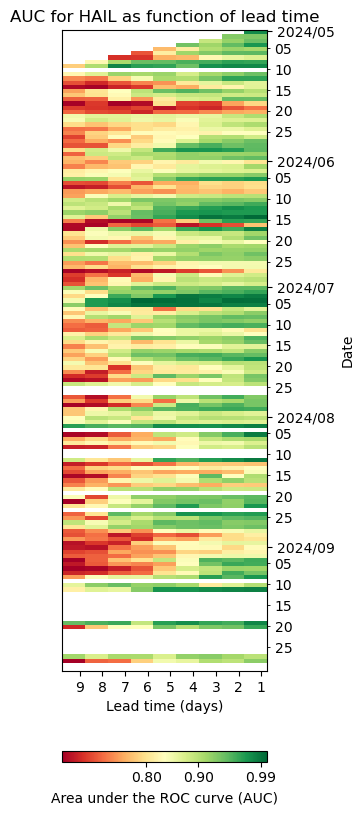

In [28]:
import datetime as dt
import matplotlib.dates as mdates

dates  = [dt.datetime.strptime(mytimestr, '%Y%m%d%H') for mytimestr in dates_fcst_24h[6]]

my_fh, my_dates = np.meshgrid(np.arange(0, auc_scores.shape[1]) * 24 + 6, dates)

#print('my_dates.shape', my_dates.shape)
#print('my_dates', my_dates[::-1, :])
#print('auc_scores', auc_scores.shape)
#print('auc_scores[:len(dates)]', auc_scores[:len(dates)].shape)

fig, ax = plt.subplots(figsize=(3, 8), layout='constrained')

plt.gca().yaxis.set_minor_formatter(mdates.DateFormatter('%d'))
plt.gca().yaxis.set_minor_locator(mdates.DayLocator(bymonthday=[1,5,10,15,20,25]))

plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
#plt.gca().yaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,5,10,15,20,25]))

from matplotlib import colors

plt.pcolormesh(my_fh[:, :-1] * (1/24) + 1, my_dates[:, :-1], auc_scores[:len(dates), :-1], cmap = 'RdYlGn', norm=colors.PowerNorm(gamma=3))
ax.set_xticks(range(1, 10, 1))

ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_title('AUC for ' + hazardtype + ' as function of lead time')
ax.set_xlabel('Lead time (days)')
ax.set_ylabel('Date')

plt.colorbar(orientation='horizontal', label='Area under the ROC curve (AUC)', ticks = [0.0, 0.8, 0.9, 0.99])
plt.savefig(hazardtype + '_AUC_leadtime.svg', bbox_inches='tight')
plt.savefig(hazardtype + '_AUC_leadtime.png', bbox_inches='tight')
plt.show()

In [29]:
print(obs_data_readin_24h.shape)
print(fcst_data_readin_24h)

(68400, 167)
{6: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 30: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 54: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), 78: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
     

In [30]:
print(observations1d)

{6: array([0., 0., 0., ..., 0., 0., 0.]), 30: array([0., 0., 0., ..., 0., 0., 0.]), 54: array([0., 0., 0., ..., 0., 0., 0.]), 78: array([0., 0., 0., ..., 0., 0., 0.]), 102: array([0., 0., 0., ..., 0., 0., 0.]), 126: array([0., 0., 0., ..., 0., 0., 0.]), 150: array([0., 0., 0., ..., 0., 0., 0.]), 174: array([0., 0., 0., ..., 0., 0., 0.]), 198: array([0., 0., 0., ..., 0., 0., 0.])}


In [31]:
#print(observations1d[6].shape)
#print(forecast1d[6].shape)
#print(lons.shape)
#print(lons.shape)

 6 20250413 09:41:52U Calculating Means 
(68400, 153)


/tmp/ipykernel_14635/2241413813.py:18: RuntimeWarning: Mean of empty slice
  mean_obs[fh] = np.nanmean(obs_data[fh], axis=1)
/tmp/ipykernel_14635/2241413813.py:19: RuntimeWarning: Mean of empty slice
  mean_fcst[fh] = np.nanmean(fcst_data[fh], axis=1)


(68400,)
 6 20250413 09:41:53U Plotting mean Obs map 
 6 20250413 09:41:53U Plotting mean Fcst map 
 30 20250413 09:41:54U Calculating Means 
(68400, 153)
(68400,)
 30 20250413 09:41:54U Plotting mean Obs map 
 30 20250413 09:41:55U Plotting mean Fcst map 
 54 20250413 09:41:55U Calculating Means 
(68400, 153)
(68400,)
 54 20250413 09:41:55U Plotting mean Obs map 
 54 20250413 09:41:56U Plotting mean Fcst map 
 78 20250413 09:41:56U Calculating Means 
(68400, 153)
(68400,)
 78 20250413 09:41:57U Plotting mean Obs map 
 78 20250413 09:41:57U Plotting mean Fcst map 


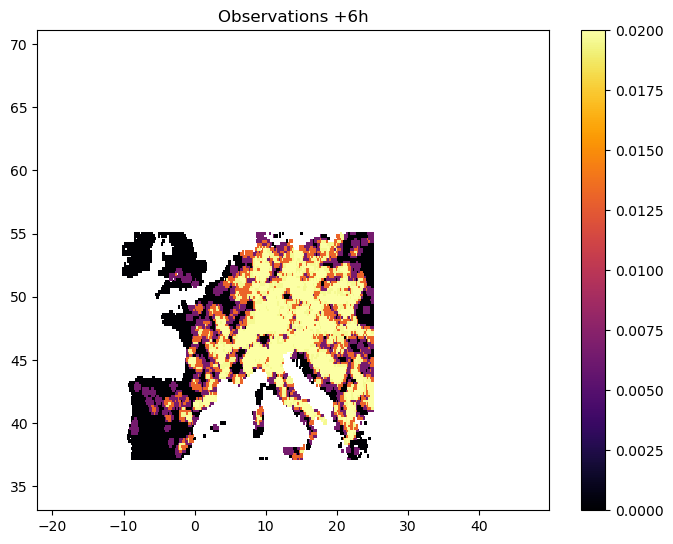

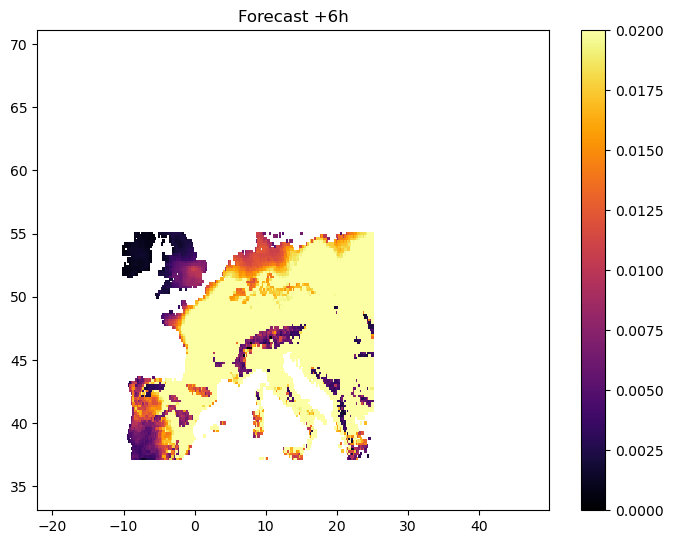

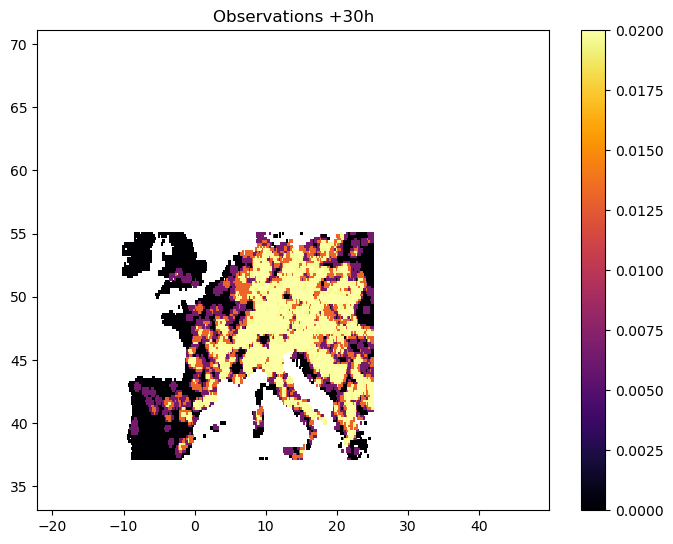

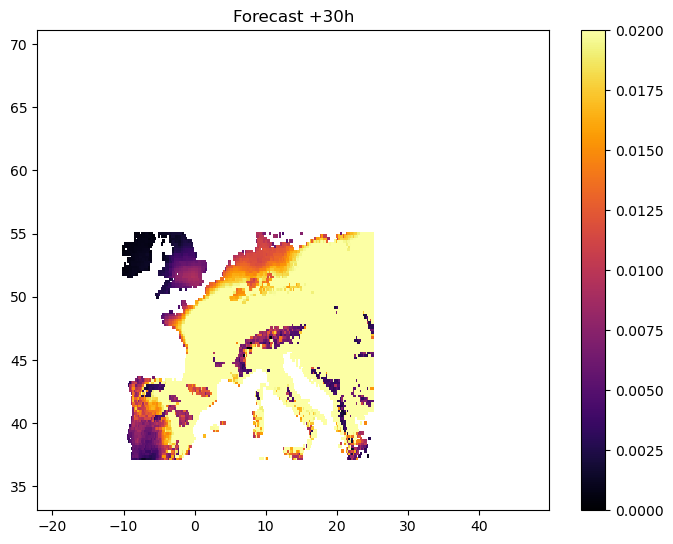

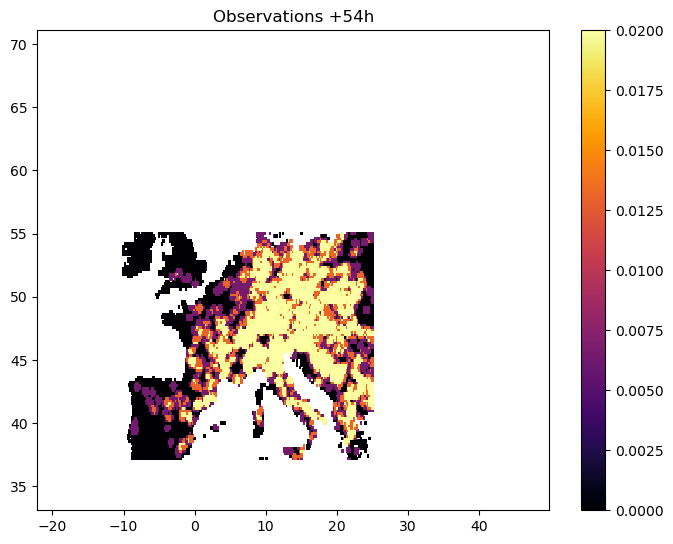

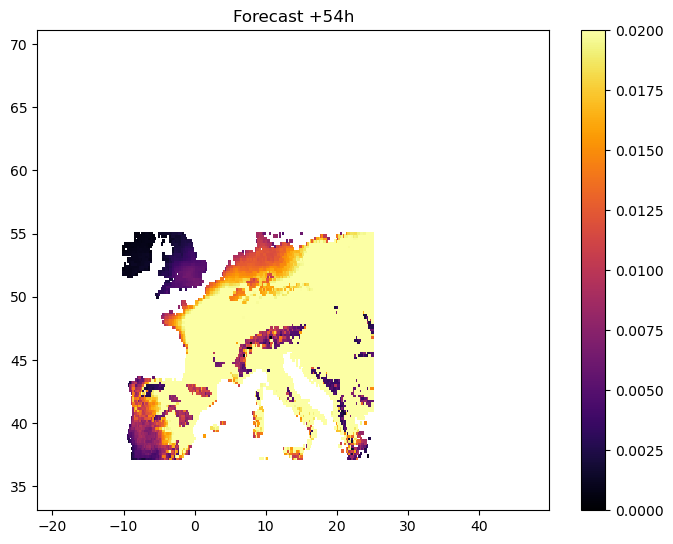

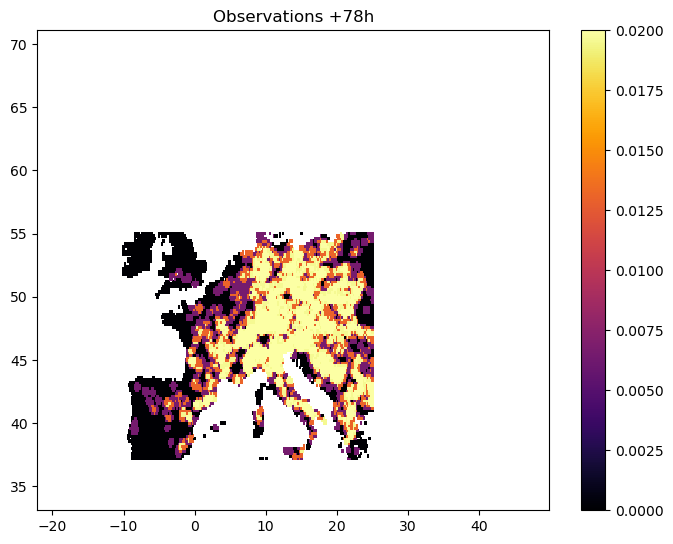

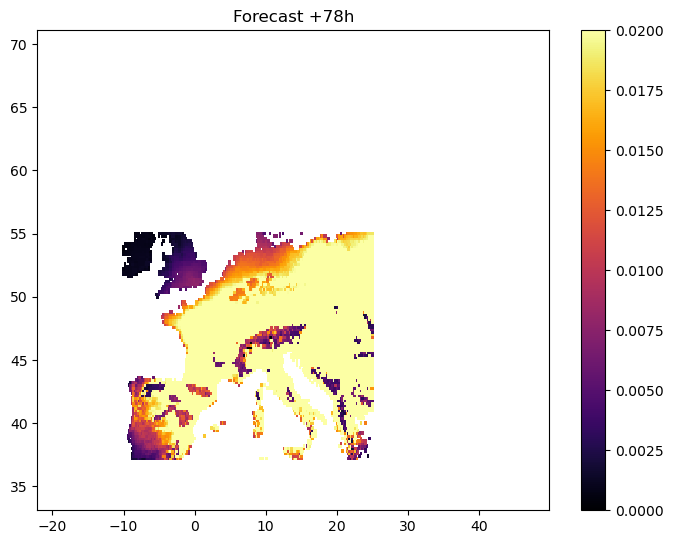

In [32]:
# SHOW SOME MAPS:

#print(lons)

plotmaps = True

if plotmaps:

    mean_obs = {}
    mean_fcst = {}
    obsmap = {}
    fcstmap = {}

    for fh in forecast_hours[0:4]:

        tu.Timestamp('Calculating Means', fh)
        print(obs_data[fh].shape)
        mean_obs[fh] = np.nanmean(obs_data[fh], axis=1)
        mean_fcst[fh] = np.nanmean(fcst_data[fh], axis=1)
        print(mean_obs[fh].shape)

        tu.Timestamp('Plotting mean Obs map', fh)

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        obsmap[fh] = ax.pcolor(lons, lats, mean_obs[fh].reshape(ny,nx), cmap='inferno', vmin=0, vmax=0.02)
        plt.title('Observations +' + str(fh) + 'h')
        plt.colorbar(obsmap[fh])
        plt.savefig(hazardtype + '_observations.png', bbox_inches='tight')

        tu.Timestamp('Plotting mean Fcst map', fh)
        fig = plt.figure()

        ax = fig.add_axes([0,0,1,1])
        fcstmap[fh] = ax.pcolor(lons, lats, mean_fcst[fh].reshape(ny,nx), cmap='inferno', vmin=0, vmax=0.02)
        plt.title('Forecast +' + str(fh) + 'h')
        plt.colorbar(fcstmap[fh])
        plt.savefig(hazardtype + '_forecasts.png', bbox_inches='tight')



In [33]:
def CalcReliability(observations1d, forecast1d, forecast_hours):
    tu.Timestamp('Calculating reliability')
    prob_trues = []
    prob_preds = []
        
    for fh in forecast_hours:
        
        tu.Timestamp(str(fh))
        print(observations1d[fh].shape, forecast1d[fh].shape)
        prob_true, prob_pred = calibration_curve(observations1d[fh], forecast1d[fh], n_bins=200, strategy='quantile')
        prob_trues.append(prob_true)
        prob_preds.append(prob_pred)
    
    return prob_trues, prob_preds

In [34]:
prob_trues, prob_preds = CalcReliability(observations1d, forecast1d, forecast_hours)


 . 20250413 09:42:03U Calculating reliability 
 . 20250413 09:42:03U 6 
(1546830,) (1546830,)
 . 20250413 09:42:04U 30 
(1546830,) (1546830,)
 . 20250413 09:42:04U 54 
(1546830,) (1546830,)
 . 20250413 09:42:04U 78 
(1546830,) (1546830,)
 . 20250413 09:42:05U 102 
(1546830,) (1546830,)
 . 20250413 09:42:05U 126 
(1546830,) (1546830,)
 . 20250413 09:42:05U 150 
(1546830,) (1546830,)
 . 20250413 09:42:06U 174 
(1546830,) (1546830,)
 . 20250413 09:42:06U 198 
(1546830,) (1546830,)


In [35]:
from cycler import cycler

def DrawReliabilityDiurnalCycle(prob_trues, prob_preds, forecast_hours): # For 6-hourly forecasts only !!!
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)

    tu.Timestamp('Plotting reliability')
    lines = []

    colorcycle = (cycler(color=['red', 'blue', 'green', 'black']))
    ax.set_prop_cycle(colorcycle)
   
    for prob_true, prob_pred, fh in zip(prob_trues, prob_preds, forecast_hours):
        plot, = ax.plot(prob_pred, prob_true, label=str(fh))
        lines.append(plot)

    ax.legend(lines[0:4], ['06-12 UTC (morning)', '12-18 UTC (afternoon)', '18-24 UTC (evening)', '00-06 UTC (night)'])
        
    ax.set_xlim([0.0,0.4])
    ax.set_ylim([0.0,0.4])
    ax.set_xlabel("Forecast Probability", fontsize=12)
    ax.set_ylabel("True Probability", fontsize=12)
    ax.grid()
        
    return


 . 20250413 09:42:06U Plotting reliability 


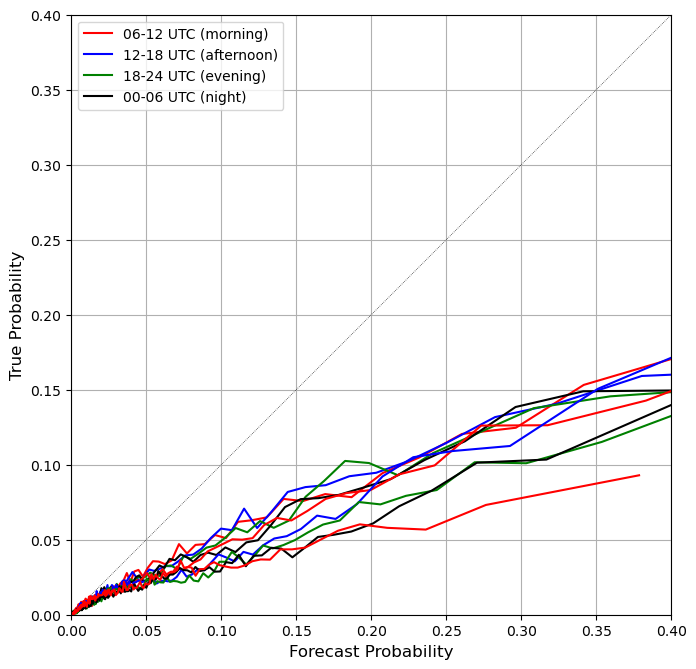

In [36]:
DrawReliabilityDiurnalCycle(prob_trues, prob_preds, forecast_hours)
plt.savefig(hazardtype + '_reliability_new.png', bbox_inches='tight')


In [37]:
def DrawReliabilityPerForecastHour(prob_trues, prob_preds, forecast_hours):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)

    tu.Timestamp('Plotting reliability')
    lines = []

    colorcycle = (cycler(color=['#ff0000', '#ff0088', '#ff00ff', '#8800ff', '#0000ff', '#0044ff', '#0088ff', '#00bbbb', '#00bb88', '#00bb00']))
    ax.set_prop_cycle(colorcycle)
   
    for prob_true, prob_pred, fh in zip(prob_trues, prob_preds, forecast_hours):
#        if int(fh + 12)%24 != 0:
#            continue
        plot, = ax.plot(prob_pred, prob_true, label='+ ' + str(fh) + ' h')
        lines.append(plot)

    ax.legend() #lines[0:4], ['06-12 UTC (morning)', '12-18 UTC (afternoon)', '18-24 UTC (evening)', '00-06 UTC (night)'])
        
    ax.set_xlim([0.0,0.3])
    ax.set_ylim([0.0,0.3])
    ax.set_xlabel("Forecast Probability", fontsize=12)
    ax.set_ylabel("True Probability", fontsize=12)
    ax.grid()
    plt.savefig(hazardtype + str(corr) + '_reliability_12UTC_new.png', bbox_inches='tight')
        
    return
    

[6, 30, 54, 78, 102, 126, 150, 174, 198]
9
9
 . 20250413 09:42:07U Plotting reliability 
 . 20250413 09:42:07U Plotting reliability 


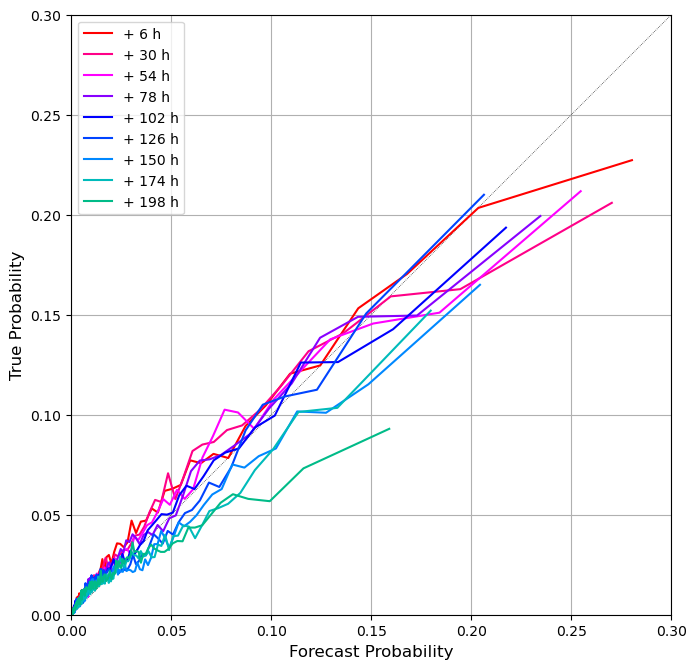

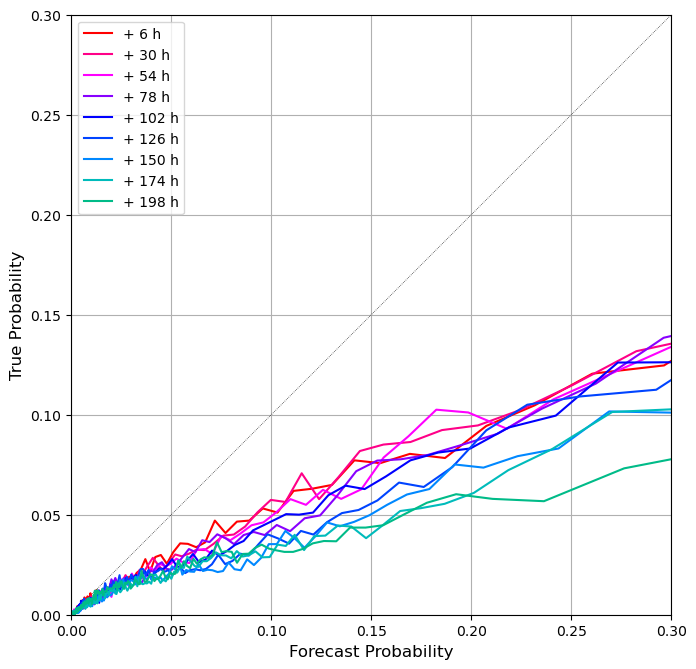

In [38]:
print(forecast_hours)
print(len(prob_trues))
print(len(prob_preds))

corr = 0.42
DrawReliabilityPerForecastHour(prob_trues, [prob * corr for prob in prob_preds], forecast_hours)

corr = 1.00
DrawReliabilityPerForecastHour(prob_trues, [prob * corr for prob in prob_preds], forecast_hours)

In [613]:
def CalcROCCurve(observations1d, forecast1d, forecast_hours):

    roc_aucs, fprs, tprs, thresholds = [], [], [], []

    tu.Timestamp('Calculating ROC curves')

    for fh in forecast_hours:
        tu.Timestamp(str(fh))
        roc_aucs.append(roc_auc_score(observations1d[fh], forecast1d[fh]))
        fpr, tpr, threshold = roc_curve(observations1d[fh], forecast1d[fh])
        fprs.append(fpr)
        tprs.append(tpr)
        thresholds.append(threshold)
    
    return roc_aucs, fprs, tprs, thresholds

In [614]:
print(observations1d[6].shape)

(1546830,)


In [615]:
roc_aucs, fprs, tprs, thresholds = CalcROCCurve(observations1d, forecast1d, forecast_hours)

 . 20250221 21:49:45U Calculating ROC curves 
 . 20250221 21:49:45U 6 
 . 20250221 21:49:46U 30 
 . 20250221 21:49:47U 54 
 . 20250221 21:49:48U 78 
 . 20250221 21:49:49U 102 
 . 20250221 21:49:50U 126 
 . 20250221 21:49:51U 150 
 . 20250221 21:49:52U 174 
 . 20250221 21:49:53U 198 


In [616]:
def DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecast_hours):

    tu.Timestamp('Plotting ROC curves')
    
    fig = plt.figure(figsize=(6,6))
    
    ax = fig.add_axes([0,0,1,1])
    diagonal = ax.plot([0,1],[0,1],'k:', linewidth=0.5)
    
    colorcycle = (cycler(color=['#ff0000', '#ff0088', '#ff00ff', '#8800ff', '#0000ff', '#0044ff', '#0088ff', '#00bbbb', '#00bb88', '#00bb00']))
    ax.set_prop_cycle(colorcycle)

    
    for roc_auc, fpr, tpr, threshold, fh in zip(roc_aucs, fprs, tprs, thresholds, forecast_hours):
        curve = ax.plot(fpr, tpr, label = '+' + str(fh) + 'h  ' + '{:.3f}'.format(roc_auc))

    ax.set_xticks(np.arange(0,1.01,0.1))
    ax.set_yticks(np.arange(0,1.01,0.1))
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel("False Alarm Rate", fontsize=12)
    ax.set_ylabel("Probability Of Detection", fontsize=12)
    ax.grid()
    
    legend = ax.legend(title='time, AUC', loc='lower right')
    
    plt.savefig(hazardtype + '_roc_curve.png', bbox_inches='tight')
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])

    #for roc_auc, fh in zip(roc_aucs, forecast_hours):
    curve = ax.plot(forecast_hours, roc_aucs)
    ax.set_xticks(np.arange(0,forecast_hours[-1],12))
    ax.set_yticks(np.arange(0.5,1.01,0.05))
    ax.set_xlim([0.0,forecast_hours[-1]])
    ax.set_ylim([0.5,1.0])
    ax.grid()
    ax.set_title('Area under ROC curve (AUC)')
    ax.set_xlabel("Forecast hour")
    ax.set_ylabel("Area under ROC curve")

    plt.savefig(hazardtype + '_auc2_new.png', bbox_inches='tight')
    
    return

 . 20250221 21:49:54U Plotting ROC curves 


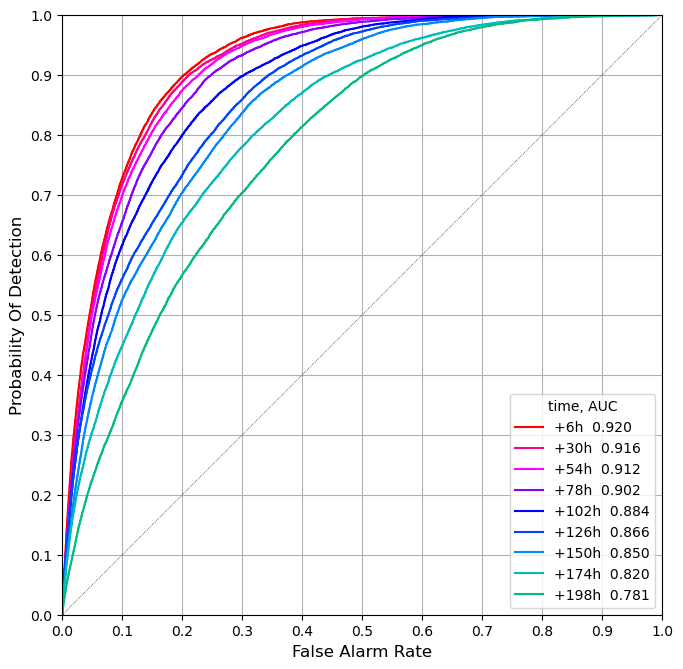

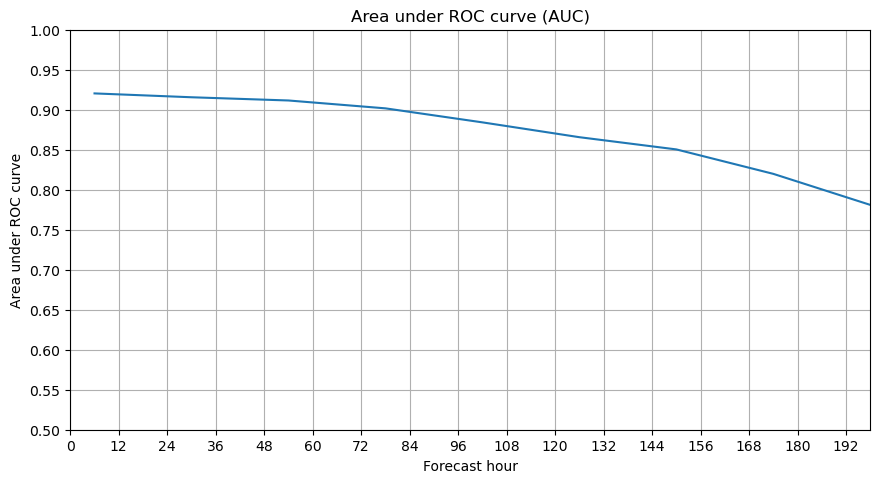

In [617]:
#DrawROCCurve(roc_aucs[1::4], fprs[1::4], tprs[1::4], thresholds[1::4], forecast_hours[1::4])
DrawROCCurve(roc_aucs, fprs, tprs, thresholds, forecast_hours)


In [618]:
bs = []
obs_freq = []
fcst_freq = []
bias = []
bs_ref = []
bskill = []

corr = 0.42

# Brier and the like...

tu.Timestamp('Calculating statistics...')

for fh in forecast_hours:    

    tu.Timestamp(str(fh))
    
    bs.append        (brier_score_loss(observations1d[fh], forecast1d[fh] * corr))

    my_obs_freq  =   np.sum(observations1d[fh])/observations1d[fh].shape[0]
    
    obs_freq.append  (my_obs_freq)
    
    my_fcst_freq =   np.sum(forecast1d[fh] * corr)/(forecast1d[fh] * corr).shape[0]
    fcst_freq.append (my_fcst_freq)

    print(fh, 'obs:', my_obs_freq, 'fcst:', my_fcst_freq, my_fcst_freq/my_obs_freq)
    
    bias.append      ((my_fcst_freq - my_obs_freq) / my_obs_freq)
    
    climatology =    np.ones((observations1d[fh].shape[0])) * my_obs_freq
    bs_ref.append    (brier_score_loss(observations1d[fh], climatology))
    bskill.append    (1 - (bs[-1] / bs_ref[-1]))
    
    
#for fh in forecast_hours:    
#    print(fh, 'Brier Score:', bs)
#    print(fh, 'Frequency: ', freq)
#    print(fh, 'Forecast frequency: ', fcst_freq)
#    print(fh, 'Bias: ', bias)
#    print(fh, 'Reference Brier Score: ', fh, bs_ref)    
#    print(fh, 'Brier Skill Score:', fh, bss)


 . 20250221 21:49:56U Calculating statistics... 
 . 20250221 21:49:56U 6 
6 obs: 0.013807593594641945 fcst: 0.011665838521799893 0.8448857103041356
 . 20250221 21:49:56U 30 
30 obs: 0.013711267560106799 fcst: 0.01179320222397891 0.8601102831871986
 . 20250221 21:49:57U 54 
54 obs: 0.013422935939954616 fcst: 0.01188156467063743 0.8851688426278522
 . 20250221 21:49:57U 78 
78 obs: 0.013391904734198328 fcst: 0.011956971580043952 0.8928507047627027
 . 20250221 21:49:57U 102 
102 obs: 0.013358934078082271 fcst: 0.01192301738298867 0.8925126296229368
 . 20250221 21:49:57U 126 
126 obs: 0.013241920573042933 fcst: 0.012248379498390393 0.9249700170626964
 . 20250221 21:49:57U 150 
150 obs: 0.01317080739318477 fcst: 0.014384221749984315 1.0921290791502596
 . 20250221 21:49:57U 174 
174 obs: 0.01315981717447942 fcst: 0.01415520265240694 1.075638245176981
 . 20250221 21:49:58U 198 
198 obs: 0.013135897286708947 fcst: 0.013587826250092284 1.0344041182356538


In [619]:
def PlotScore(param, paramshortname, paramname, forecast_hours):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])

    curve = ax.plot(forecast_hours, param)
    ax.set_xticks(np.arange(0,forecast_hours[-1],12))
    ax.set_xlim([0.0,forecast_hours[-1]])
    ax.grid()
    ax.set_title(paramname)
    ax.set_xlabel("Forecast hour")
    ax.set_ylabel(paramshortname)

    plt.savefig(hazardtype + '_' + paramshortname + '.png', bbox_inches='tight')
    return

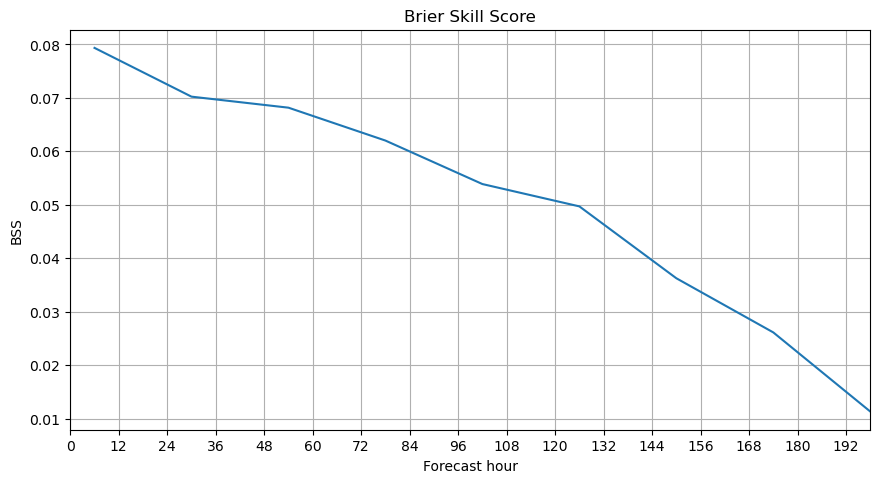

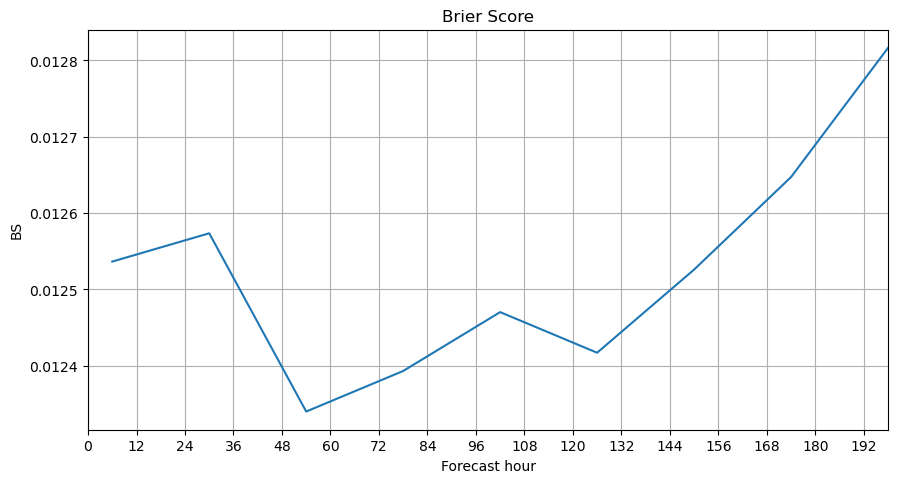

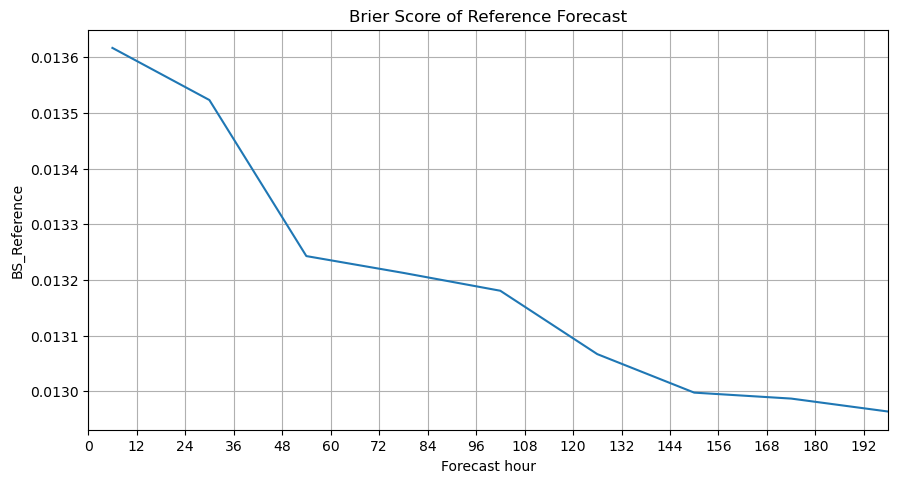

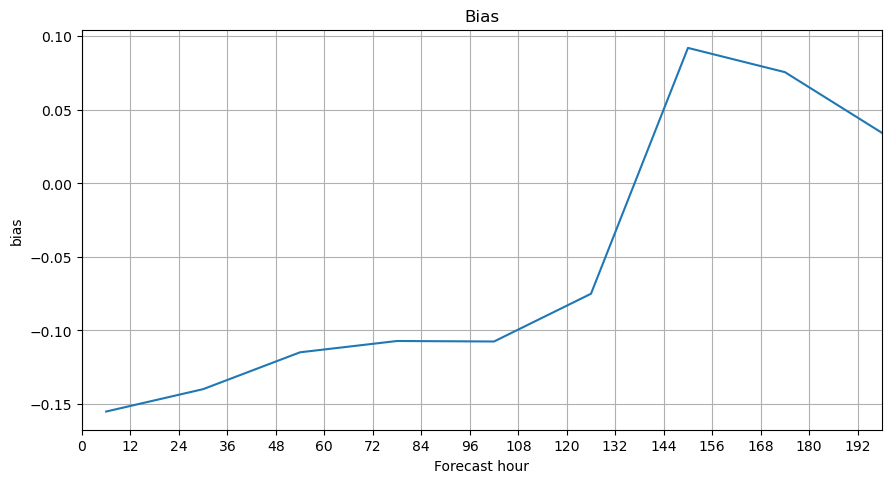

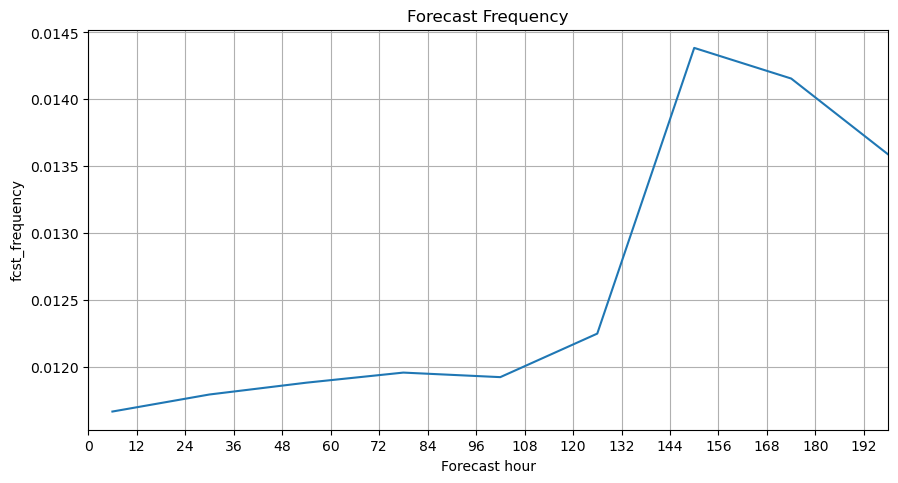

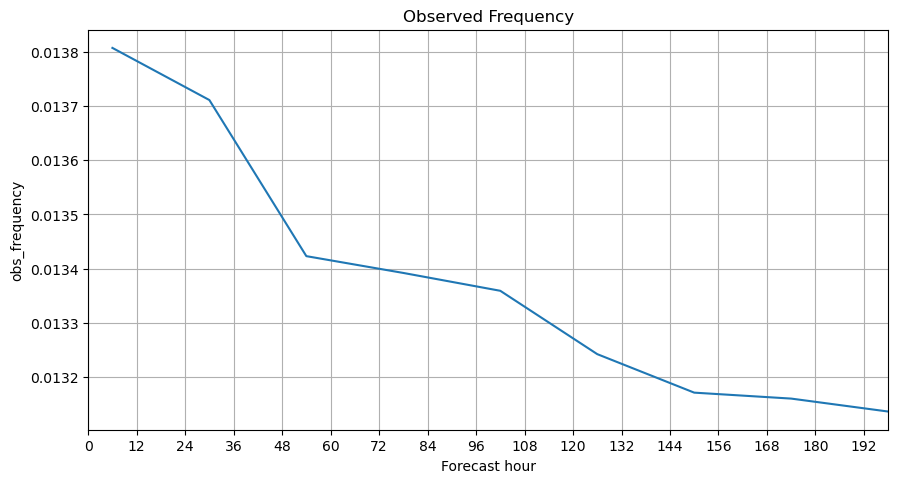

In [620]:
PlotScore(bskill, 'BSS', 'Brier Skill Score', forecast_hours)
PlotScore(bs, 'BS', 'Brier Score', forecast_hours)
PlotScore(bs_ref, 'BS_Reference', 'Brier Score of Reference Forecast', forecast_hours)
PlotScore(bias, 'bias', 'Bias', forecast_hours)
PlotScore(fcst_freq, 'fcst_frequency', 'Forecast Frequency', forecast_hours)
PlotScore(obs_freq, 'obs_frequency', 'Observed Frequency', forecast_hours)

In [621]:
def PlotObsForecastScore(observed, forecast, forecast_hours):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])

    curves = []
    curve, = ax.plot(forecast_hours, observed, label='observed')

    curves.append(curve)
    curve, = ax.plot(forecast_hours, forecast, label='forecast')
    curves.append(curve)
    
    ax.set_xticks(np.arange(0,forecast_hours[-1],12))
    #ax.set_yticks(np.arange(0.5,1.01,0.05))
    ax.set_xlim([0.0,forecast_hours[-1]])
    #ax.set_ylim([0.5,1.0])
    ax.grid()
#    ax.set_title(paramname)
    ax.set_xlabel("Forecast hour")
    ax.set_ylabel("frequency")
    ax.legend()
    
    plt.savefig(hazardtype + '_obsfcst.png', bbox_inches='tight')
    return

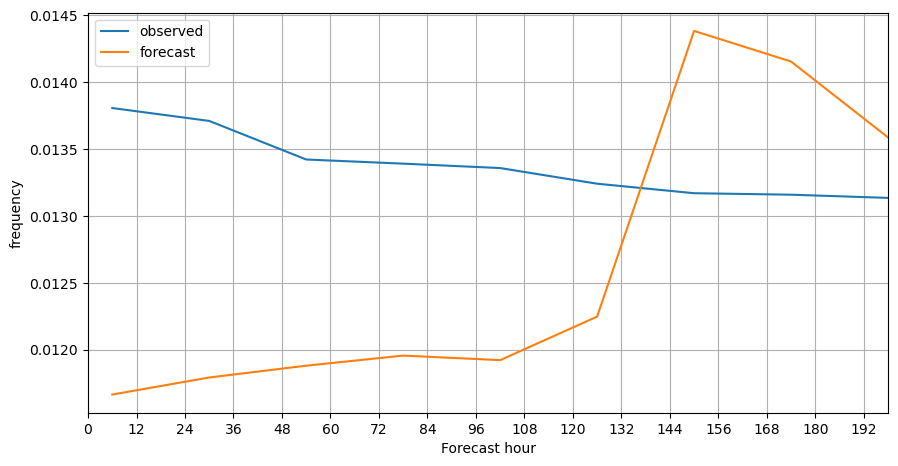

In [622]:
#check selection of second 3-hrly period
#24h forecasts?
#bias-corrected 6h forecasts?

PlotObsForecastScore(obs_freq, fcst_freq, forecast_hours)

In [623]:
a = np.array([1, 2, 3])

b = np.array([4, 5, 6])

c = np.vstack((a,b))

In [576]:
d = np.vstack((c,b))

In [577]:
d

array([[1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])